In [1]:
from IPython.display import clear_output
!pip install mteb
!pip install -q transformers accelerate bitsandbytes
!pip install qpsolvers
!pip install hf_xet
!pip install --upgrade --pre numpy
clear_output()

In [2]:
import pickle
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import mteb

import torch
from transformers import AutoTokenizer, AutoModel
from mteb.encoder_interface import Encoder
from typing import List, Dict, Optional, Sequence
import torch.nn.functional as F

# from qpsolvers import solve_qp
import cvxpy as cp

import os, gc
import json
from tqdm.auto import tqdm
from datasets import load_dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

from sklearn.decomposition import IncrementalPCA
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
def save_res(dct, path):
  with open(path, 'wb') as handle:
      pickle.dump(dct, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_res(path):
  try:
    with open(path, 'rb') as handle:
      results = pickle.load(handle)
  except:
    results = {}

  return results

DEVICE = torch.device('cuda')

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
MODEL_NAME = "princeton-nlp/sup-simcse-bert-base-uncased"
BATCH_SIZE = 512
MAX_LEN    = 256
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

BASE_PATH = '/content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/'


#из схожести слоев
CLUSTERS =  [[0, 1, 2], [3, 4, 5, 6, 7, 8, 9, 10], [11, 12], [13]]

# Классы

In [5]:
class MultiLayerEncoderMean(Encoder):
    """
    Простой энкодер:
      • pooling="mean" — sentence embedding = mean-pool по токенам
      • pooling="cls"  — sentence embedding = CLS последнего слоя
    """

    def __init__(
        self,
        model_name: str = "princeton-nlp/sup-simcse-bert-base-uncased",
        pooling: str = "cls",          # "mean" | "cls"
        max_len: int = MAX_LEN,
    ):
        super().__init__()
        assert pooling in {"mean", "cls"}, "pooling должен быть 'mean' или 'cls'"
        self.pooling = pooling
        self.max_len = MAX_LEN

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model = AutoModel.from_pretrained(
            model_name,
            output_hidden_states=False,        # не нужны все слои
            device_map="auto"
        ).eval()

    @torch.inference_mode()
    def encode(
        self,
        sentences: List[str],
        gpu_sub_batch: int = BATCH_SIZE,
        **kwargs,
    ) -> torch.Tensor:

        all_vecs = []

        for start in range(0, len(sentences), gpu_sub_batch):
            batch = sentences[start:start + gpu_sub_batch]

            inputs = self.tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            ).to(self.model.device)

            outs = self.model(**inputs)

            if self.pooling == "cls":
                # 1) предпочтительно pooler_output (SimCSE, BERT), иначе CLS из last_hidden_state
                if hasattr(outs, "pooler_output") and outs.pooler_output is not None:
                    vecs = outs.pooler_output            # [B, H]
                else:
                    print('shit damn')
                    # vecs = outs.last_hidden_state[:, 0]  # CLS токен
            else:  # mean-pool
                mask = inputs["attention_mask"].unsqueeze(-1)  # [B, T, 1]
                vecs = (outs.last_hidden_state * mask).sum(1) / mask.sum(1).clamp(min=1e-9)

            all_vecs.append(vecs.cpu())

            # очистка памяти GPU
            del outs, inputs
            torch.cuda.empty_cache()

        return torch.cat(all_vecs, dim=0)


In [6]:
def qadr_solve(acc, sim, lmbd=1.0):
    """
    acc  — numpy-массив [L], качество каждого слоя
    sim  — numpy-матрица [L x L], похожесть (CKA / RSA / corr)
    lmbd — коэффициент штрафа за дублирование (λ)

    Возвращает оптимальные веса слоёв [L], сумма = 1, все ≥ 0
    """
    acc = np.asarray(acc)
    sim = np.asarray(sim)
    L = len(acc)

    w = cp.Variable(L, nonneg=True)                       # веса ≥ 0
    objective = cp.Maximize(acc @ w - lmbd * cp.quad_form(w, sim))
    constraints = [cp.sum(w) == 1]                        # сумма = 1
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return w.value

In [8]:
from scipy.optimize import minimize

def qadr_solve_greedy(acc, sim, lmbd=1.0, alpha=1.0):
    n = len(acc)
    mask = (acc[None, :] > acc[:, None]).astype(float)
    A    = sim * mask
    np.fill_diagonal(A, alpha)      # самоподобие

    def obj(w, q, A, lam):
        pen  = w @ A @ w
        val  = -(q @ w - lam*pen)
        grad = -(q - lam * (A + A.T) @ w)
        return val, grad

    w0 = np.full(n, 1/n)
    cons = [{'type':'eq', 'fun':lambda w: w.sum()-1},
            {'type':'ineq','fun':lambda w: w}]
    res = minimize(lambda w,*a: obj(w,*a), w0, args=(acc,A,lmbd),
                   jac=True, method='SLSQP', constraints=cons)
    return res.x

In [7]:
def opt_full(a, corr_matrix, n = 6):
  """
  полная оптимизация из статьи Beyond simple average
  """
  P = 2 * corr_matrix
  c = np.diag(corr_matrix)
  q = a - c
  A = np.ones((1, corr_matrix.shape[0]))
  b = np.ones(1)
  lb = np.zeros(corr_matrix.shape[0])
  ub = np.ones(corr_matrix.shape[0])
  x_sol = solve_qp(P, q, A=A, b=b, lb=lb, ub=ub, initvals=np.ones(n)*1/n, solver='cvxopt', verbose=False)
  return x_sol

In [9]:
class MultiLayerEncoderWeighted(Encoder):
    """
    Взвешенное усреднение нескольких слоёв + pooler_output (как «слой» pooler_idx).
    ─────────────────────────────────────────────────────────────────────────────
    layer_indices  — список индексов слоёв, который МОЖЕТ содержать pooler_idx
                     (по умолчанию 13 для base-моделей; можно переопределить).
    layer_weights  — такие же по длине веса; дальше L2-нормируются.
    pooling        — 'cls' | 'mean' к каждому выбранному слою (кроме pooler).
    """
    def __init__(
        self,
        model_name: str,
        layer_indices: List[int],
        layer_weights: List[float],
        pooling: str = "mean",
        max_len: int = MAX_LEN,
        pooler_idx: int | None = None,   # если None → автоматически = num_hidden_layers+1
    ):
        super().__init__()
        assert pooling in {"mean", "cls"}, "pooling должен быть 'mean' или 'cls'"
        assert len(layer_indices) == len(layer_weights), "layer_indices и layer_weights разных размеров"

        self.pooling   = pooling
        self.max_len   = max_len

        # ── модель ───────────────────────────────────────
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model     = AutoModel.from_pretrained(
            model_name,
            output_hidden_states=True,
            device_map="auto"
        ).eval()

        # pooler считается дополнительным «слоем» с индексом num_hidden_layers+1
        self.pooler_idx = pooler_idx if pooler_idx is not None \
                          else self.model.config.num_hidden_layers + 1

        # проверяем, что индексы валидны
        max_valid_idx = self.model.config.num_hidden_layers          # последний hidden_state
        for i in layer_indices:
            if i != self.pooler_idx and not (0 <= i <= max_valid_idx):
                raise ValueError(f"layer index {i} вне диапазона 0…{max_valid_idx} "
                                 f"или не равен pooler_idx {self.pooler_idx}")

        self.layer_indices = layer_indices
        # приведём веса к тензору и L2-нормализуем, чтобы их сумма в квадрате = 1
        w = torch.tensor(layer_weights, dtype=torch.float32)
        self.layer_weights = w / w.norm(p=2)

    # ────────────────────────────────────────────────────────
    #  Encodе
    # ────────────────────────────────────────────────────────
    @torch.inference_mode()
    def encode(
        self,
        sentences: List[str],
        gpu_sub_batch: int = BATCH_SIZE,
        **kwargs
    ) -> torch.Tensor:

        all_vecs = []

        for start in range(0, len(sentences), gpu_sub_batch):
            batch = sentences[start:start + gpu_sub_batch]

            inputs = self.tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            ).to(self.model.device)

            outputs        = self.model(**inputs)
            hidden_states  = outputs.hidden_states      # tuple: [emb, h1, …, h_last]
            mask           = inputs["attention_mask"].unsqueeze(-1).float()

            layer_vecs = []
            for i in self.layer_indices:
                # ─ pooler_output как отдельный «слой» ─
                if i == self.pooler_idx:
                    if outputs.pooler_output is None:
                        raise RuntimeError("У модели нет pooler_output")
                    vec = outputs.pooler_output                       # [B, H]
                else:
                    h = hidden_states[i]                              # [B, T, H]
                    if self.pooling == "cls":
                        vec = h[:, 0, :]                              # CLS
                    else:  # mean pooling с маской
                        vec = (h * mask).sum(1) / mask.sum(1).clamp(min=1e-9)

                layer_vecs.append(vec)

            # ─ взвешенное суммирование ─
            stacked  = torch.stack(layer_vecs, dim=0)                 # [k, B, H]
            weights  = self.layer_weights.to(stacked.device).view(-1, 1, 1)
            weighted = (stacked * weights).sum(0)                     # [B, H]

            all_vecs.append(weighted.cpu())

            # очистка памяти
            del outputs, hidden_states, stacked, weighted, inputs
            torch.cuda.empty_cache()

        return torch.cat(all_vecs, dim=0)


In [10]:
def cluster_concat_pca(
    embeddings: torch.Tensor,          # [B, L, S, H]
    attention_mask: torch.Tensor,      # [B, S]
    weights: torch.Tensor,
    clusters: Sequence[Sequence[int]],
    pooling: str = "mean",
    *,
    pooler_output: torch.Tensor | None = None,   # [B, H]
    pooler_idx: int = 13,
    pca_components: torch.Tensor | None = None,
    pca_mean: torch.Tensor | None = None,
):
    """Агрегирует слои внутри каждого кластера, учитывая, что
    индекс `pooler_idx` означает pooler_output, а не hidden_state.
    """
    device, dtype = embeddings.device, embeddings.dtype
    weights       = weights.to(device=device, dtype=dtype)

    if pooler_output is not None:
        pooler_output = pooler_output.to(device=device, dtype=dtype)

    cluster_vecs: List[torch.Tensor] = []

    # 1‑2. среднее по слоям кластера + токен‑pooling / pooler
    for cid, cl in enumerate(clusters):
        per_layer_vecs = []
        for idx in cl:
            if idx == pooler_idx:                     # ─ pooler_output ─
                if pooler_output is None:
                    raise ValueError("pooler_output не передан, но pooler_idx встречается в кластере")
                vec_layer = pooler_output             # [B, H]
            else:                                     # ─ обычный слой ─
                h = embeddings[:, idx, :, :]          # [B, S, H]
                if pooling == "cls":
                    vec_layer = h[:, 0, :]            # CLS
                elif pooling == "mean":
                    mask = attention_mask.unsqueeze(-1).float()
                    vec_layer = (h * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
                else:
                    raise ValueError(f"Unknown pooling = {pooling}")
            per_layer_vecs.append(vec_layer)          # [B, H]

        # среднее по слоям внутри кластера
        cl_vec = torch.stack(per_layer_vecs, dim=0).mean(0)  # [B, H]
        cl_vec = cl_vec * weights[cid]
        cluster_vecs.append(cl_vec)

    # 3. конкатенация кластеров
    concat_vec = torch.cat(cluster_vecs, dim=-1)               # [B, concat_dim]

    # 4. PCA‑проекция (если даны).
    if pca_components is None:
        return concat_vec.to(dtype)

    if pca_mean is not None:
        concat_vec = concat_vec - pca_mean.to(device, dtype)

    return (concat_vec @ pca_components.T.to(device, dtype))   # [B, out_dim]

In [11]:
class MultiLayerEncoder(Encoder):
    def __init__(
        self,
        clusters,
        pca_components,
        pca_mean,
        weights,
        *,
        pooling: str = "mean",
        model_name: str = "princeton-nlp/sup-simcse-bert-base-uncased",
        pooler_idx: int | None = None,
        max_len: int = MAX_LEN,
    ):
        super().__init__()
        assert pooling in {"mean", "cls"}
        self.pooling = pooling

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model     = AutoModel.from_pretrained(
            model_name,
            output_hidden_states=True,
            device_map="auto"
        ).eval()

        # pooler_idx по умолчанию = num_hidden_layers + 1
        self.pooler_idx = pooler_idx if pooler_idx is not None \
                           else self.model.config.num_hidden_layers + 1

        self.clusters       = [list(cl) for cl in clusters]
        self.pca_components = pca_components
        self.pca_mean       = pca_mean
        self.weights        = torch.tensor(weights, dtype=torch.float32)

    # -----------------------------------------------------------------
    @torch.inference_mode()
    def encode(self, sentences, gpu_sub_batch=BATCH_SIZE, **kwargs):
        all_vecs = []
        for s in range(0, len(sentences), gpu_sub_batch):
            batch = sentences[s: s + gpu_sub_batch]
            inputs = self.tokenizer(
                batch, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt"
            ).to(self.model.device)

            with torch.no_grad():
                outs = self.model(**inputs)

            # hidden_states: tuple(len=L) → [L, B, S, H] → [B, L, S, H]
            hidden = torch.stack(outs.hidden_states).permute(1, 0, 2, 3)

            vecs = cluster_concat_pca(
                hidden,
                inputs["attention_mask"],
                clusters       = self.clusters,
                pooling        = self.pooling,
                pca_components = self.pca_components,
                pca_mean       = self.pca_mean,
                weights        = self.weights,
                pooler_output  = outs.pooler_output,
                pooler_idx     = self.pooler_idx,
            ).cpu()

            all_vecs.append(vecs)

            # очистка
            del outs, hidden, inputs, vecs
            torch.cuda.empty_cache(); gc.collect()

        return torch.cat(all_vecs, dim=0)


In [12]:
# def greedy_layer_selection(q, S, lmbd=0.5, top_n=None):
#     """
#     Жадный выбор лучших top_n слоёв по качеству и разнообразию.

#     Аргументы:
#         q      : (L,) массив качеств слоёв
#         S      : (L, L) матрица похожестей слоёв (CKA, RSA и т.п.)
#         lmbd   : баланс между качеством и разнообразием
#         top_n  : сколько слоёв выбрать (обязательный параметр)

#     Возвращает:
#         selected_layers,: список индексов выбранных слоёв (в порядке выбора)
#         weights        : нормализованные веса слоёв (0 для неиспользуемых)
#     """
#     assert top_n is not None and top_n > 0, "top_n должен быть задан явно"

#     q = np.array(q, dtype=np.float32)
#     S = np.array(S, dtype=np.float32)
#     L = len(q)

#     selected = []
#     remaining = set(range(L))
#     # weights = np.zeros(top_n, dtype=np.float32)

#     for step in range(top_n):
#         best_gain = -np.inf
#         best_idx = None

#         for i in remaining:
#             gain_quality = q[i]
#             penalty = np.mean([S[i][j] for j in selected]) if selected else 0.0
#             gain = gain_quality - lmbd * penalty

#             if gain > best_gain:
#                 best_gain = gain
#                 best_idx = i

#         if best_idx is None:
#             break

#         selected.append(best_idx)
#         remaining.remove(best_idx)

#     # Назначаем веса: чем раньше выбран слой, тем выше вес
#     rank_weights = np.array([1.0 / (i + 1) for i in range(len(selected))], dtype=np.float32)
#     rank_weights /= rank_weights.sum()

#     return selected, rank_weights

In [13]:
def greedy_layer_selection(
    q: np.ndarray,
    S: np.ndarray,
    *,
    lmbd: float = 0.5,
    max_n: int | None = None,
    min_gain: float = 0.0,
    norm: str = "minmax"
):
    """Greedy + веса = нормированные приросты gain."""
    # --- нормализация метрик (как раньше) --------------------
    q = np.asarray(q, np.float32)
    if norm == "minmax":
        q = (q - q.min()) / (q.max() - q.min() + 1e-9)
    elif norm == "zscore":
        z = (q - q.mean()) / (q.std() + 1e-9)
        q = (z - z.min()) / (z.max() - z.min() + 1e-9)
    elif norm == "baseline":
        base = q[-1]; q = np.maximum((q - base) / (abs(base) + 1e-9), 0.0)
    elif norm != "none":
        raise ValueError("unknown norm")

    S = np.asarray(S, np.float32)
    selected, gains = [], []          # сохраним приросты
    remaining = set(range(len(q)))
    step = 0

    while remaining and (max_n is None or step < max_n):
        best_gain, best_idx = -np.inf, None
        for i in remaining:
            penalty = np.mean([S[i, j] for j in selected]) if selected else 0.0
            gain    = q[i] - lmbd * penalty
            if gain > best_gain:
                best_gain, best_idx = gain, i

        if best_gain < min_gain:
            break                     # ранний стоп

        selected.append(best_idx)
        gains.append(best_gain)       # фиксируем прирост
        remaining.remove(best_idx)
        step += 1

    # --- веса из gain ----------------------------------------
    gains = np.array(gains, dtype=np.float32)
    if gains.sum() == 0:
        weights = np.ones_like(gains) / len(gains)      # fallback
    else:
        weights = gains / gains.sum()                   # нормируем в 1.0

    return selected, weights


In [14]:
def greedy_layer_selection_v3(
    q: np.ndarray,
    S: np.ndarray,
    *,
    lmbd: float = 0.5,          # баланс «качество — разнообразие»
    drop_delta: float = 0.15,   # отсекаем слои, у которых quality
                                # < (1-drop_delta)·q_max
    max_n: int | None = None,   # жёстный максимум (None → без потолка)
):
    """
    1. Удаляем все слои, чьё «качество» хуже чем на `drop_delta·100 %`
       от лучшего (raw-метрики, без нормировки).
    2. На оставшихся выполняем greedy-алгоритм
       (quality − λ·similarity) с нормировкой quality → [0,1].
    3. Веса = ранговые (1, 1/2, 1/3 …) и нормируются до 1.0.

    Параметры
    ---------
    q : (L,)  массив исходных (ненормированных) качеств слоёв
    S : (L,L) матрица похожести (0 … 1, меньше = разнообразнее)
    lmbd       : вес penalty
    drop_delta : доля ухудшения от лучшего, ниже которой слой отбрасывается
                 (0.15 ⇒ берём только те, что ≥ 85 % max(q))
    max_n      : максимум слоёв после фильтра. None ⇒ без ограничения

    Возврат
    -------
    selected : list[int]     индексы выбранных слоёв
    weights  : np.ndarray    ранговые веса, сумма = 1
    """

    q_raw = np.asarray(q, np.float32)
    S     = np.asarray(S, np.float32)

    # --- 1. Фильтр по качеству -----------------------------------------
    q_max = q_raw.max()
    keep  = np.where(q_raw >= (1.0 - drop_delta) * q_max)[0]
    if keep.size == 0:
        raise ValueError("Все слои отфильтрованы: увеличьте drop_delta")

    q_filt = q_raw[keep]
    S_filt = S[np.ix_(keep, keep)]

    # --- 2. Нормировка quality → [0,1] ---------------------------------
    # q_norm = (q_filt - q_filt.min()) / (q_filt.max() - q_filt.min() + 1e-9)

    remaining = set(range(len(keep)))   # индексы в filt-пространстве
    selected_local = []
    while remaining and (max_n is None or len(selected_local) < max_n):
        best_gain, best_idx = -np.inf, None
        for i in remaining:
            penalty = np.mean([S_filt[i, j] for j in selected_local]) if selected_local else 0.0
            gain = q_filt[i] - lmbd * penalty
            if gain > best_gain:
                best_gain, best_idx = gain, i
        if best_idx is None:
            break
        selected_local.append(best_idx)
        remaining.remove(best_idx)

    # --- 3. Ранговые веса ----------------------------------------------
    rank_w = np.array([1 / (k + 1) for k in range(len(selected_local))], np.float32)
    rank_w /= rank_w.sum()

    # переведём индексы обратно к оригинальной нумерации слоёв
    selected_global = [int(keep[i]) for i in selected_local]
    return selected_global, rank_w

In [15]:
class SelectedLayersEncoder(Encoder):
    """Формирует эмбеддинг как взвешенную сумму выбранных слоёв + pooler_output.

    * `selected_layers` — список индексов. Если индекс равен `pooler_idx`,
      вместо hidden‑state берётся `outputs.pooler_output`.
    * `layer_weights`   — коэффициенты той же длины.
    """
    def __init__(
        self,
        selected_layers: List[int],
        layer_weights : List[float],
        *,
        pooling   : str = "mean",              # 'cls' | 'mean'
        model_name: str = "princeton-nlp/sup-simcse-bert-base-uncased",
        max_len   : int = MAX_LEN,
        pooler_idx: int | None = None,
    ):
        super().__init__()
        assert pooling in {"mean", "cls"}
        assert len(selected_layers) == len(layer_weights), "layer_weights != selected_layers"

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model     = AutoModel.from_pretrained(
            model_name, output_hidden_states=True, device_map="auto"
        ).eval()

        self.pooler_idx = pooler_idx if pooler_idx is not None \
                          else self.model.config.num_hidden_layers + 1

        max_hid = self.model.config.num_hidden_layers
        for idx in selected_layers:
            if idx != self.pooler_idx and not (0 <= idx <= max_hid):
                raise ValueError(f"layer index {idx} вне диапазона 0…{max_hid} или pooler_idx {self.pooler_idx}")

        self.selected_layers = selected_layers
        self.layer_weights   = torch.tensor(layer_weights, dtype=torch.float32)
        self.pooling         = pooling
        self.max_len         = max_len

    # ------------------------------------------------------------
    @torch.inference_mode()
    def encode(self, sentences: List[str], gpu_sub_batch: int = BATCH_SIZE, **kw) -> torch.Tensor:
        all_vecs = []
        for s in range(0, len(sentences), gpu_sub_batch):
            batch = sentences[s:s+gpu_sub_batch]
            inp   = self.tokenizer(batch, padding=True, truncation=True,
                                   max_length=self.max_len, return_tensors="pt"
                                   ).to(self.model.device)
            with torch.no_grad():
                outs = self.model(**inp)
                hs   = torch.stack(outs.hidden_states, dim=0)   # [L, B, T, H]

            vecs=[]
            for i, idx in enumerate(self.selected_layers):
                # ─ pooler_output ─
                if idx == self.pooler_idx:
                    if outs.pooler_output is None:
                        raise RuntimeError("У модели нет pooler_output, но он запрошен в selected_layers")
                    v = outs.pooler_output                       # [B, H]
                else:
                    h = hs[idx]                                  # [B,T,H]
                    if self.pooling == "cls":
                        v = h[:,0,:]
                    else:                                        # mean pooling
                        mask = inp["attention_mask"].unsqueeze(-1).float()
                        v = (h*mask).sum(1) / mask.sum(1).clamp(min=1e-9)

                vecs.append(v * self.layer_weights[i])

            all_vecs.append(torch.stack(vecs).sum(0).cpu())
            del inp, outs, hs; torch.cuda.empty_cache(); gc.collect()
        return torch.cat(all_vecs,0)


In [16]:
# class SingleLayerEncoder(Encoder):
#     def __init__(self, layer_idx:int, *, pooling="cls", model_name=MODEL_NAME,
#                  pooler_idx=None, max_len=MAX_LEN):
#         assert pooling in {"mean", "cls"}
#         self.pooling = pooling
#         self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
#         self.model     = AutoModel.from_pretrained(model_name, output_hidden_states=True).to(DEVICE).eval()

#         self.pooler_idx = pooler_idx if pooler_idx is not None else self.model.config.num_hidden_layers + 1
#         max_idx = self.model.config.num_hidden_layers
#         if layer_idx != self.pooler_idx and not (0 <= layer_idx <= max_idx):
#             raise ValueError(f"layer {layer_idx} out of range or not pooler_idx {self.pooler_idx}")
#         self.layer_idx = layer_idx
#         self.max_len   = max_len

#     @torch.inference_mode()
#     def encode(self, texts: list[str], **kwargs):
#         out=[]
#         for i in range(0,len(texts), BATCH_SIZE):
#             batch = texts[i:i+BATCH_SIZE]
#             enc   = self.tokenizer(batch, padding="max_length", truncation=True,
#                                    max_length=self.max_len, return_tensors="pt").to(DEVICE)
#             outs  = self.model(**enc)
#             if self.layer_idx == self.pooler_idx:
#                 v = outs.pooler_output                     # [B,H]
#             else:
#                 h = outs.hidden_states[self.layer_idx]     # [B,S,H]
#                 if self.pooling=="cls":
#                     v = h[:,0]
#                 else:
#                     m = enc.attention_mask.unsqueeze(-1)
#                     v = (h*m).sum(1) / m.sum(1).clamp(min=1e-9)
#             out.append(v.cpu().numpy())
#             del enc, outs, v; torch.cuda.empty_cache(); gc.collect()
#         return np.vstack(out)

In [17]:
class SingleLayerEncoder(Encoder):
    """
    Эмбеддинг одного слоя или pooler_output.

    * `layer_idx == pooler_idx` → берётся `outs.pooler_output`.
    * pooling: 'cls' | 'mean' (для скрытых слоёв).
    """
    def __init__(
        self,
        layer_idx: int,
        *,
        pooling: str = "mean",                              # 'cls' | 'mean'
        model_name: str = "princeton-nlp/sup-simcse-bert-base-uncased",
        max_len: int = MAX_LEN,
        pooler_idx: int | None = None,
    ):
        super().__init__()
        assert pooling in {"mean", "cls"}

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model     = AutoModel.from_pretrained(
            model_name, output_hidden_states=True, device_map="auto"
        ).eval()

        self.pooler_idx = pooler_idx if pooler_idx is not None \
                          else self.model.config.num_hidden_layers + 1

        max_hid = self.model.config.num_hidden_layers
        if layer_idx != self.pooler_idx and not (0 <= layer_idx <= max_hid):
            raise ValueError(f"layer {layer_idx} вне диапазона 0…{max_hid} "
                             f"или не равен pooler_idx {self.pooler_idx}")

        self.layer_idx = layer_idx
        self.pooling   = pooling
        self.max_len   = max_len

    # ------------------------------------------------------------------
    @torch.inference_mode()
    def encode(self, sentences: List[str], gpu_sub_batch: int = BATCH_SIZE, **_) -> torch.Tensor:
        device = next(self.model.parameters()).device
        out = []

        for s in range(0, len(sentences), gpu_sub_batch):
            batch = sentences[s:s + gpu_sub_batch]

            enc = self.tokenizer(
                batch,
                padding=True,           # минимальный паддинг
                truncation=True,
                max_length=MAX_LEN,
                return_tensors="pt"
            ).to(device)

            # fp16-инференс даёт ≈-35 % ускорения на Ampere+
            # with torch.autocast(device.type, dtype=torch.float16, enabled=device.type == "cuda"):
            outs = self.model(**enc)

            if self.layer_idx == self.pooler_idx:          # pooler_output
                vec = outs.pooler_output                   # [B, H]
            else:                                          # скрытый слой
                h = outs.hidden_states[self.layer_idx]     # [B, T, H]
                if self.pooling == "cls":
                    vec = h[:, 0]                          # CLS
                else:                                      # mean-pool
                    msk = enc.attention_mask.unsqueeze(-1).float()
                    vec = (h * msk).sum(1) / msk.sum(1).clamp(min=1e-9)

            out.append(vec.cpu())                          # tensor → CPU

        return torch.cat(out, 0)


In [18]:
def evaluate_layer(layer_idx:int, *, part_val="dev", max_iter=100, pooling="mean", pooler_idx=None):
    """Обучает LogisticRegression на тренировочной выборке и оценивает на валидации."""

    enc = SingleLayerEncoder(layer_idx, pooling=pooling, pooler_idx=pooler_idx)

    X_train = enc.encode(ds_splits["train"]["text"])
    X_val   = enc.encode(ds_splits[part_val]["text"])

    clf = LogisticRegression(max_iter=max_iter)
    clf.fit(X_train, ds_splits["train"]["label"])

    preds  = clf.predict(X_val)
    acc    = accuracy_score(ds_splits[part_val]["label"], preds)
    report = classification_report(ds_splits[part_val]["label"], preds, zero_division=0)

    return {"accuracy": acc, "report": report}


In [19]:
def evaluate_layer_nfcorpus(encoder, queries, corpus, relevance, top_k=10):
    query_texts  = [q["text"] for q in queries]
    corpus_texts = [c["text"] for c in corpus]

    # Кодируем
    query_embs  = encoder.encode(query_texts)
    corpus_embs = encoder.encode(corpus_texts)

    # ID → индекс
    qid_to_idx = {q["_id"]: i for i, q in enumerate(queries)}
    cid_to_idx = {c["_id"]: i for i, c in enumerate(corpus)}

    # Релевантные документы
    relevant_docs = {}
    for row in relevance:
        qid, cid, score = row["query-id"], row["corpus-id"], row["score"]
        if qid in qid_to_idx and cid in cid_to_idx:
            relevant_docs.setdefault(qid, set()).add(cid)

    # Similarity
    sim_matrix = cosine_similarity(query_embs, corpus_embs)

    # Recall@k
    recalls = []
    for q in queries:
        qid = q["_id"]
        if qid not in relevant_docs:
            continue

        q_idx = qid_to_idx[qid]
        top_k_idx = np.argsort(sim_matrix[q_idx])[-top_k:][::-1]
        top_k_cids = [corpus[i]["_id"] for i in top_k_idx]

        is_hit = any(cid in relevant_docs[qid] for cid in top_k_cids)
        recalls.append(int(is_hit))

    recall = np.mean(recalls)
    return recall


In [20]:
def ndcg_at_k(relevance_scores, k=10):
    """relevance_scores: список релевантностей в порядке ранжирования"""
    dcg = 0.0
    for i, rel in enumerate(relevance_scores[:k]):
        dcg += rel / np.log2(i + 2)
    # идеальная DCG (сортировка по убыванию релевантности)
    ideal = sorted(relevance_scores, reverse=True)[:k]
    idcg = sum(r / np.log2(i + 2) for i, r in enumerate(ideal))
    return dcg / idcg if idcg > 0 else 0.0

def evaluate_layer_ndcg(encoder, queries, corpus, relevance, top_k=10):
    query_texts  = [q["text"] for q in queries]
    corpus_texts = [c["text"] for c in corpus]

    query_embs  = encoder.encode(query_texts)
    corpus_embs = encoder.encode(corpus_texts)

    qid_to_idx = {q["_id"]: i for i, q in enumerate(queries)}
    cid_to_idx = {c["_id"]: i for i, c in enumerate(corpus)}
    cid_from_idx = {i: c["_id"] for i, c in enumerate(corpus)}

    # relevance dict: qid → {cid: score}
    rel_scores = {}
    for row in relevance:
        qid, cid, score = row["query-id"], row["corpus-id"], row["score"]
        if qid in qid_to_idx and cid in cid_to_idx:
            rel_scores.setdefault(qid, {})[cid] = score

    sim_matrix = cosine_similarity(query_embs, corpus_embs)

    ndcgs = []
    for q in queries:
        qid = q["_id"]
        if qid not in rel_scores:
            continue

        q_idx = qid_to_idx[qid]
        scores = sim_matrix[q_idx]
        top_k_idx = np.argsort(scores)[-top_k:][::-1]
        top_k_cids = [cid_from_idx[i] for i in top_k_idx]

        # relevance for retrieved docs
        relevance_at_k = [rel_scores[qid].get(cid, 0) for cid in top_k_cids]
        ndcg = ndcg_at_k(relevance_at_k, k=top_k)
        ndcgs.append(ndcg)

    return np.mean(ndcgs)

In [21]:
from scipy.stats import spearmanr

def evaluate_layer_spearman(encoder, dataset):
    sents1 = [row["sentence1"] for row in dataset]
    sents2 = [row["sentence2"] for row in dataset]
    gold_scores = [row["score"] for row in dataset]

    emb1 = encoder.encode(sents1)
    emb2 = encoder.encode(sents2)

    cos_sims = np.array([
        cosine_similarity(e1.reshape(1, -1), e2.reshape(1, -1))[0, 0]
        for e1, e2 in zip(emb1, emb2)
    ])

    rho, _ = spearmanr(cos_sims, gold_scores)
    return rho

In [22]:
from sklearn.metrics import average_precision_score


def evaluate_layer_ap(encoder, dataset):

    sents1 = dataset['sent1'][0]
    sents2 = dataset['sent2'][0]
    labels = dataset['labels'][0]

    emb1 = encoder.encode(sents1)
    emb2 = encoder.encode(sents2)

    similarities = np.array([
        cosine_similarity(e1.reshape(1, -1), e2.reshape(1, -1))[0, 0]
        for e1, e2 in zip(emb1, emb2)
    ])

    ap = average_precision_score(labels, similarities)
    return ap

In [23]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.cluster import KMeans
import numpy as np

def evaluate_clustering_nmi(encoder, dataset):
    texts = dataset["sentences"]
    labels = dataset["labels"]
    n_clusters = len(set(labels))

    embs = encoder.encode(texts)
    preds = KMeans(n_clusters=n_clusters, n_init=10).fit_predict(embs)

    return normalized_mutual_info_score(labels, preds)


In [24]:
class SelectedLayersPCAEncoder(Encoder):
    """Concat √w_i·v_i выбранных слоёв (или pooler) → (опц.) центрирование → PCA."""
    def __init__(self, layers: List[int], weights: torch.Tensor, pca_components: torch.Tensor,
                 pca_mean: torch.Tensor | None = None, *, pooling="mean",
                 model_name=MODEL_NAME, max_len=MAX_LEN, pooler_idx=None):
        assert pooling in {"mean", "cls"}
        assert len(layers) == len(weights), "weights length must match layers"

        self.layers   = layers
        self.weights  = weights.float()
        self.weights_sqrt = self.weights.sqrt()           # √w_i

        self.pca_components = pca_components.float()
        self.pca_mean       = pca_mean.float() if pca_mean is not None else None
        self.pooling  = pooling
        self.max_len  = max_len

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model     = AutoModel.from_pretrained(model_name, output_hidden_states=True, device_map="auto").eval()
        self.pooler_idx = pooler_idx if pooler_idx is not None else self.model.config.num_hidden_layers + 1
        max_idx = self.model.config.num_hidden_layers
        for idx in layers:
            if idx != self.pooler_idx and not (0 <= idx <= max_idx):
                raise ValueError("Layer index out of range or not pooler_idx")

    # ------------------------------------------------------------
    @torch.inference_mode()
    def encode(self, sentences: List[str], gpu_sub_batch=64, **kwargs):
        out_list=[]
        for s in range(0,len(sentences),gpu_sub_batch):
            batch = sentences[s:s+gpu_sub_batch]
            inp   = self.tokenizer(batch, padding=True, truncation=True, max_length=self.max_len, return_tensors="pt").to(self.model.device)
            out   = self.model(**inp)
            hs    = torch.stack(out.hidden_states)  # [L,B,S,H]

            vecs=[]
            for idx, w_sqrt in zip(self.layers, self.weights_sqrt):
                if idx == self.pooler_idx:
                    v = out.pooler_output                    # [B,H]
                else:
                    h = hs[idx]
                    if self.pooling=="cls":
                        v = h[:,0]
                    else:
                        m = inp["attention_mask"].unsqueeze(-1).float(); v = (h*m).sum(1)/m.sum(1).clamp(min=1e-9)
                vecs.append(v * w_sqrt.to(v.device))

            concat = torch.cat(vecs, -1)                     # [B, concat_dim]
            if self.pca_mean is not None:
                concat = concat - self.pca_mean.to(concat.device, concat.dtype)
            proj = concat @ self.pca_components.T.to(concat.device, concat.dtype)
            out_list.append(proj.cpu())
            del inp,out,hs; torch.cuda.empty_cache(); gc.collect()
        return torch.cat(out_list,0)

In [25]:
def train_pca_from_clusters(
    *,
    clusters: Sequence[Sequence[int]],
    cluster_weights: Sequence[float],
    task_name: str,
    model_name: str = MODEL_NAME,
    n_sentences: int = 30_000,
    batch_gpu: int = 64,
    out_dim: int = 768,
    pooling: str = "mean",  # 'cls' | 'mean'
    dataset_name: str = "allenai/c4",
    dataset_subset: str = "en",
    max_len: int = MAX_LEN,
    save_dir: str | None = None,
    collect: int | None = None,
) -> tuple[str, dict]:
    """IncrementalPCA on √‑weighted concat of clusters.

    Identical (VRAM‑wise) to the original standalone script that used
    `torch.stack(hidden_states)` and worked with batch_gpu=512.
    """

    assert pooling in {"cls", "mean"}, "pooling must be 'cls' or 'mean'"

    save_dir = save_dir or os.path.join(BASE_PATH, "PCA")
    os.makedirs(save_dir, exist_ok=True)

    collect = collect or max(out_dim, 2048)

    # 1. Corpus ---------------------------------------------------
    ds = load_dataset(dataset_name, dataset_subset, split="train", streaming=True)
    texts = [
        ex["text"]
        for ex in ds.shuffle(buffer_size=n_sentences, seed=42).take(n_sentences)
    ]

    # 2. Model ----------------------------------------------------
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    mdl = AutoModel.from_pretrained(model_name, output_hidden_states=True).to(device).eval()

    pooler_idx = mdl.config.num_hidden_layers + 1  # 13 for *‑base

    # 3. Weights --------------------------------------------------
    w = np.asarray(cluster_weights, dtype=np.float32)
    w = w / w.sum()
    w_sqrt = torch.tensor(w, dtype=torch.float32)

    # 4. PCA ------------------------------------------------------
    ipca = IncrementalPCA(n_components=out_dim, batch_size=512)
    buffer: list[np.ndarray] = []
    buf_len = 0

    def flush_to_pca() -> None:
        nonlocal buffer, buf_len
        if buf_len:
            ipca.partial_fit(np.vstack(buffer))
            buffer.clear()
            buf_len = 0
            torch.cuda.empty_cache()
            gc.collect()

        # 5. Main loop ----------------------------------------------
    with torch.no_grad():
        for start in tqdm(range(0, len(texts), batch_gpu), desc="PCA train batches"):
            batch = texts[start : start + batch_gpu]
            enc = tok(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_len,
            ).to(device)

            outs = mdl(**enc)
            hidden = torch.stack(outs.hidden_states, 0).float()  # [L,B,T,H]
            mask = enc.attention_mask.unsqueeze(-1).float()

            vecs = []
            for idx, cl in enumerate(clusters):
                layer_sents = []
                for layer in cl:
                    if layer == pooler_idx:                      # pooler_output – [B,H]
                        sent_l = outs.pooler_output
                    else:                                        # обычный слой – [B,T,H]
                        h_l = hidden[layer]
                        if pooling == "cls":
                            sent_l = h_l[:, 0, :]
                        else:
                            sent_l = (h_l * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
                    layer_sents.append(sent_l)

                # среднее по слоям внутри кластера (B,H)
                cluster_vec = torch.stack(layer_sents, 0).mean(0) * w_sqrt[idx].to(device)
                vecs.append(cluster_vec)

            concat = torch.cat(vecs, dim=-1).cpu().numpy()
            buffer.append(concat)
            buf_len += concat.shape[0]

            if buf_len >= collect:
                flush_to_pca()

            del outs, hidden, enc, concat, vecs
            torch.cuda.empty_cache()
            gc.collect()

    flush_to_pca()

    # 6. Save -----------------------------------------------------
    ckpt = {
        "components": torch.tensor(ipca.components_, dtype=torch.float32),
        "mean": torch.tensor(ipca.mean_, dtype=torch.float32),
        "clusters": [list(cl) for cl in clusters],
        "weights": torch.tensor(w, dtype=torch.float32),
        "hidden_size": 768,
        "pooling": pooling,
    }

    out_path = os.path.join(save_dir, f"pca_clusters_{task_name}.pt")
    torch.save(ckpt, out_path)
    print(f"✓ PCA saved → {out_path}")

    return out_path, ckpt

In [26]:
from typing import List, Sequence, Tuple, Optional

def train_pca_from_selected_layers(
    *,
    selected_layers: Sequence[int],          # индексы слоёв (pooler_idx допустим)
    layer_weights:  Sequence[float],         # такие же по длине веса
    task_name:      str,                     # метка для имени файла
    model_name:     str  = "princeton-nlp/sup-simcse-bert-base-uncased",
    n_sentences:    int  = 30_000,
    batch_gpu:      int  = 256,
    out_dim:        int  = 768,
    pooling:        str  = "mean",            # 'cls' | 'mean'
    dataset_name:   str  = "allenai/c4",
    dataset_subset: str  = "en",
    max_len:        int  = MAX_LEN,
    save_dir:       str  = "./PCA",
    collect:        int  | None = None,      # размер буфера перед partial_fit
) -> Tuple[str, dict]:
    """
    Обучает IncrementalPCA на √-взвешенной конкатенации *выбранных* слоёв
    (учитывается и pooler_output). Логика полностью повторяет ваш
    «рабочий» скрипт.

    Возвращает путь к .pt-файлу c PCA и сам checkpoint.
    """
    assert pooling in {"cls", "mean"}, "pooling должен быть 'cls' или 'mean'"
    assert len(selected_layers) == len(layer_weights), "`layer_weights` и `selected_layers` разной длины"

    os.makedirs(save_dir, exist_ok=True)
    collect = collect or max(out_dim, 2048)

    # 1. Корпус ─────────────────────────────────────────────
    ds = load_dataset(dataset_name, dataset_subset, split="train", streaming=True)
    texts = [ex["text"] for ex in ds.shuffle(buffer_size=n_sentences, seed=42).take(n_sentences)]

    # 2. Модель ─────────────────────────────────────────────
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    mdl = AutoModel.from_pretrained(model_name, output_hidden_states=True).to(device).eval()
    pooler_idx = mdl.config.num_hidden_layers + 1          # 13 для base

    # 3. Нормализация весов ────────────────────────────────
    w = np.asarray(layer_weights, dtype=np.float32)
    w = w / w.sum()
    w_sqrt = torch.tensor(w, dtype=torch.float32).sqrt()    # √w

    # 4. PCA и буфер ────────────────────────────────────────
    ipca   = IncrementalPCA(n_components=out_dim, batch_size=512)
    buffer: list[np.ndarray] = []
    buf_len = 0
    def flush() -> None:
        nonlocal buffer, buf_len
        if buf_len:
            ipca.partial_fit(np.vstack(buffer))
            buffer.clear(); buf_len = 0
            torch.cuda.empty_cache(); gc.collect()

    # 5. Главный цикл ──────────────────────────────────────
    with torch.no_grad():
        for start in tqdm(range(0, len(texts), batch_gpu), desc="PCA batches"):
            batch = texts[start : start + batch_gpu]
            enc = tok(batch, padding=True, truncation=True,
                      max_length=max_len, return_tensors="pt").to(device)
            outs = mdl(**enc)
            hidden = torch.stack(outs.hidden_states, 0)      # [L,B,T,H]
            mask   = enc.attention_mask.unsqueeze(-1).float()

            vecs = []
            for idx, layer_idx in enumerate(selected_layers):
                if layer_idx == pooler_idx:
                    sent = outs.pooler_output                          # [B,H]
                else:
                    h_l = hidden[layer_idx]                            # [B,T,H]
                    if pooling == "cls":
                        sent = h_l[:, 0, :]
                    else:
                        sent = (h_l * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
                vecs.append(sent * w_sqrt[idx].to(device))             # √wᵢ · vᵢ

            concat = torch.cat(vecs, dim=-1).cpu().numpy()             # [B, len*H]
            buffer.append(concat); buf_len += concat.shape[0]
            if buf_len >= collect:
                flush()

            del enc, outs, hidden, concat, vecs
            torch.cuda.empty_cache(); gc.collect()

    flush()  # финальный сброс

    # 6. Сохранение ─────────────────────────────────────────
    ckpt = {
        "components" : torch.tensor(ipca.components_, dtype=torch.float32),
        "mean"       : torch.tensor(ipca.mean_,       dtype=torch.float32),
        "layers"     : list(selected_layers),
        "weights"    : torch.tensor(w, dtype=torch.float32),
        "hidden_size": 768,
        "pooling"    : pooling,
    }
    out_path = os.path.join(save_dir, f"pca_selected_layers_{task_name}.pt")
    torch.save(ckpt, out_path)
    print(f"✓ PCA saved → {out_path}")

    return out_path, ckpt


# Проверка методов

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model     = AutoModel.from_pretrained(
                      MODEL_NAME, output_hidden_states=True
                  ).to(DEVICE).eval()
texts = ['df,vkndfkvjdfnvkjdf  dfnkvjdnfb vbhkj bvf', 'kdjnvb dfvndjfk dfnvkjdfvn dfv']
enc = tokenizer(
            texts,
            padding="max_length",
            truncation=True,
            max_length=MAX_LEN,
            return_tensors="pt"
        ).to(DEVICE)
h  = model(**enc).hidden_states

len(h)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

13

In [ ]:
out = model(**enc)

In [ ]:
out.pooler_output

tensor([[ 0.1888,  0.1315, -0.0071,  ...,  0.0037, -0.0118, -0.1521],
        [ 0.0762,  0.1251,  0.0006,  ...,  0.0360,  0.0696, -0.1033]],
       device='cuda:0', grad_fn=<TanhBackward0>)

In [ ]:
out.last_hidden_state[:, 0, :]

tensor([[0.2194, 0.0847, 0.6800,  ..., 0.3231, 0.2801, 0.0836],
        [0.0402, 0.0811, 0.4768,  ..., 0.2695, 0.2881, 0.0856]],
       device='cuda:0', grad_fn=<SliceBackward0>)

# Banking77Classification

In [27]:
task_names = ['Banking77Classification']
sim_matr = load_res(BASE_PATH + 'CKA.pkl')

## Качество отдельных слоев на dev

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0.  Параметры
# ─────────────────────────────────────────────────────────────
PATH = BASE_PATH + 'layer_Banking77Classification'

# ─────────────────────────────────────────────────────────────
# 1.  Загружаем датасет с вашими сплитами
# ─────────────────────────────────────────────────────────────

ds = load_dataset("mteb/banking77")


# Разбиваем train → 80% train + 20% validation
train_val = ds["train"].train_test_split(test_size=0.2, seed=42)
ds_splits = DatasetDict({
    "train":      train_val["train"],
    "dev": train_val["test"],
    "test":       ds["test"]
})

# ─────────────────────────────────────────────────────────────
# 4.  Прогоняем по слоям 0–12
# ─────────────────────────────────────────────────────────────
all_results = {}
for layer in range(14):
    print(f"\n>>> Layer {layer}")
    res = evaluate_layer(layer, part_val = 'dev', max_iter = 500)
    print(f"Accuracy: {res['accuracy']:.4f}")
    # print(res["report"])
    all_results[layer] = res
    save_res(all_results, PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



>>> Layer 0
Accuracy: 0.9040

>>> Layer 1
Accuracy: 0.9015

>>> Layer 2
Accuracy: 0.9030

>>> Layer 3
Accuracy: 0.9025

>>> Layer 4
Accuracy: 0.8996

>>> Layer 5
Accuracy: 0.9070

>>> Layer 6
Accuracy: 0.9010

>>> Layer 7
Accuracy: 0.9030

>>> Layer 8
Accuracy: 0.9005

>>> Layer 9
Accuracy: 0.8961

>>> Layer 10
Accuracy: 0.8991

>>> Layer 11
Accuracy: 0.9025

>>> Layer 12
Accuracy: 0.9025

>>> Layer 13
Accuracy: 0.8996


In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'

res = load_res(PATH)

acc = [i['accuracy'] for i in res.values()]

best_layer = np.argmax(acc).item()
best_layer

5

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + "last_mean_mask_Banking77Classification",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

train.jsonl:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/365k [00:00<?, ?B/s]

main_score =  0.7583116883116883
CPU times: user 33.2 s, sys: 2.41 s, total: 35.6 s
Wall time: 43.5 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder= BASE_PATH + "best_dev_Banking77Classification",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.7016558441558441
CPU times: user 31 s, sys: 354 ms, total: 31.3 s
Wall time: 32.4 s


## Взвешанное среднее

In [28]:
layer_acc = load_res(BASE_PATH + 'layer_Banking77Classification')
acc = np.array([i['accuracy'] for i in  layer_acc.values()])

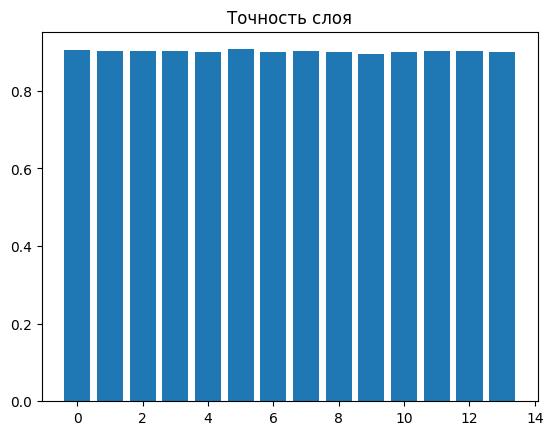

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
# plt.ylim(0.86, 0.91)
plt.show()

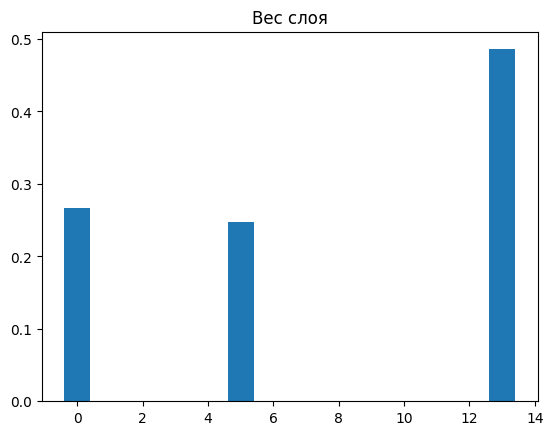

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + "layer_qp_mean_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.7632142857142856
CPU times: user 29.5 s, sys: 588 ms, total: 30.1 s
Wall time: 30.3 s


## QP nonsym

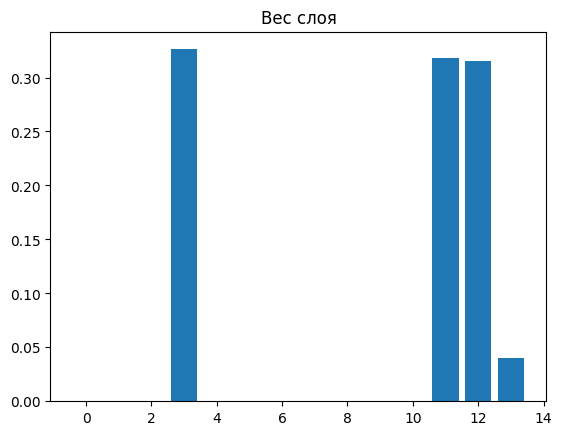

In [29]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [30]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/365k [00:00<?, ?B/s]

main_score =  0.7591233766233765
CPU times: user 34.8 s, sys: 2.39 s, total: 37.2 s
Wall time: 53.3 s


## PCA сlusters

CLUSTERS:  [[0, 1, 2], [3, 4, 5, 6, 7, 8, 9, 10], [11, 12], [13]]


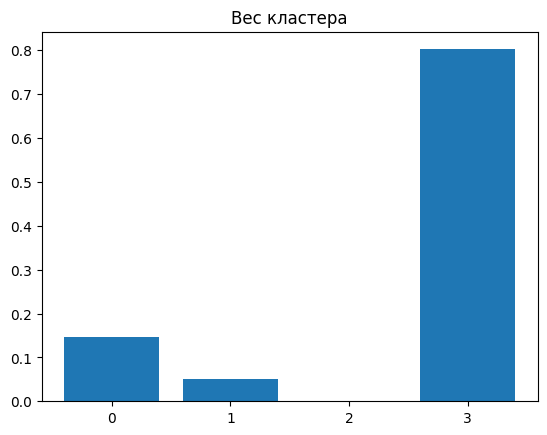

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
PATH = BASE_PATH + 'PCA/'
N_SENTENCES = 30_000
BATCH_GPU = 256

HIDDEN_SIZE = 768
CONCAT_DIM = HIDDEN_SIZE * len(CLUSTERS)
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)
POOLING = 'mean'


# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()
pooler_idx = mdl.config.num_hidden_layers + 1      # 13 для *-base

# ─────────────────────────────────────────────────────────────
# 3. Цикл по типам задач и их весам
# ─────────────────────────────────────────────────────────────

print(f"\n=== Обучение PCA для задачи: {task_names[0]} ===")

# Нормализация весов (на всякий случай)
weights = np.array(cluster_weights, dtype=np.float32)
weights = weights / weights.sum()
WEIGHTS = torch.tensor(weights)

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt",
                  padding=True, truncation=True, max_length=MAX_LEN
                 ).to(device)

        outs = mdl(**enc)                            # hidden + pooler
        h    = torch.stack(outs.hidden_states, 0)    # [L, B, T, H]

        vecs = []
        for idx_cl, cl in enumerate(CLUSTERS):
            per_layer_reprs = []

            for layer in cl:
                # ---- pooler_output как отдельный «слой» ----
                if layer == pooler_idx:
                    sent_repr = outs.pooler_output                # [B, H]
                else:                                             # обычный слой
                    h_l = h[layer]                                # [B, T, H]
                    if POOLING == "cls":
                        sent_repr = h_l[:, 0, :]                  # CLS
                    else:                                         # mean-pool
                        msk = enc.attention_mask.unsqueeze(-1).float()
                        sent_repr = (h_l * msk).sum(1) / msk.sum(1).clamp(min=1e-9)
                per_layer_reprs.append(sent_repr)

            # среднее по слоям внутри кластера (+ вес √w)
            cluster_vec = torch.stack(per_layer_reprs, 0).mean(0) * WEIGHTS[idx_cl].sqrt()
            vecs.append(cluster_vec)

        concat = torch.cat(vecs, -1).cpu().numpy()                # [B, concat_dim]

        buffer.append(concat)
        buf_len += concat.shape[0]
        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()


# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохраняем результат для задачи
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "clusters":   CLUSTERS,
    "weights":    WEIGHTS,
    "hidden_size": HIDDEN_SIZE,
    "pooling":    POOLING,            #  ←  сохраняем режим
}

out_path = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")


=== Обучение PCA для задачи: Banking77Classification ===


  0%|          | 0/118 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/PCA/pca_divercity_Banking77Classification.pt


In [ ]:
CKPT_PATH  = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
ckpt = torch.load(CKPT_PATH, map_location="cpu")

In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = ckpt['pooling'],
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + "concat_pca_cluster_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

<ipython-input-12-6cedec8fb49f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights        = torch.tensor(weights, dtype=torch.float32)


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.7588636363636364


## PCA QP

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0. Параметры
# ─────────────────────────────────────────────────────────────
PATH = BASE_PATH + 'PCA/'
POOLING = 'mean'
N_SENTENCES = 30_000
BATCH_GPU = 256

HIDDEN_SIZE = 768
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# отобранные слои и их веса
selected_layers = weights_idx
final_acc = final_acc
final_acc /= final_acc.sum()  # нормализация
layer_weights = torch.tensor(final_acc, dtype=torch.float32)



# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()
pooler_idx = mdl.config.num_hidden_layers + 1      # 13 для *-base

# ─────────────────────────────────────────────────────────────
# 3. Обучение PCA на выбранных слоях
# ─────────────────────────────────────────────────────────────
print(f"\n=== Обучение PCA по отобранным слоям: {selected_layers.tolist()} ===")

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc   = tok(batch, return_tensors="pt",
                    padding=True, truncation=True, max_length=MAX_LEN
                   ).to(device)
        outs  = mdl(**enc)
        h     = torch.stack(outs.hidden_states, 0)   # [L, B, T, H]

        vecs = []
        for w_sqrt, layer_idx in zip(layer_weights.sqrt(), selected_layers):
            # ── pooler_output как отдельный «слой» ─────────────────
            if layer_idx == pooler_idx:
                sent = outs.pooler_output                     # [B, H]
            else:
                v = h[layer_idx]                              # [B, T, H]
                if POOLING == "cls":
                    sent = v[:, 0, :]                         # CLS
                else:                                         # mean-pool
                    m = enc.attention_mask.unsqueeze(-1).float()
                    sent = (v * m).sum(1) / m.sum(1).clamp(min=1e-9)
            # ────────────────────────────────────────────────────────
            vecs.append(sent * w_sqrt.to(sent.device))        # √w · vec

        concat = torch.cat(vecs, dim=-1).cpu().numpy()        # [B, len*H]
        buffer.append(concat);  buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat; gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохранение PCA
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "layers":     selected_layers.tolist(),
    "weights":    layer_weights,
    "hidden_size": HIDDEN_SIZE,
    "pooling": POOLING
}
out_path = os.path.join(PATH, f"pca_qadr_layers_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")


=== Обучение PCA по отобранным слоям: [0, 5, 13] ===


  0%|          | 0/118 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/PCA/pca_qadr_layers_Banking77Classification.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + "concat_pca_qp_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.7601298701298702


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + "concat_pca_qp_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 14)

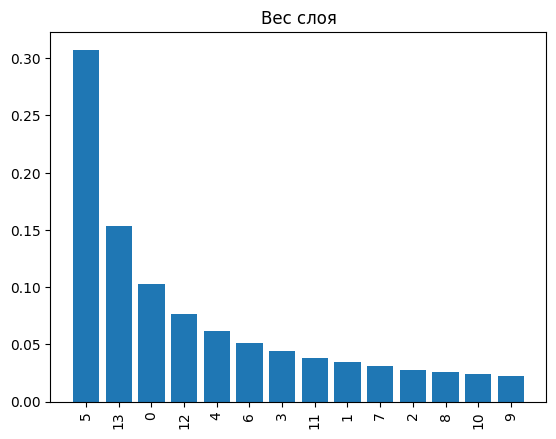

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="cls",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + "greedy_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.7072402597402597


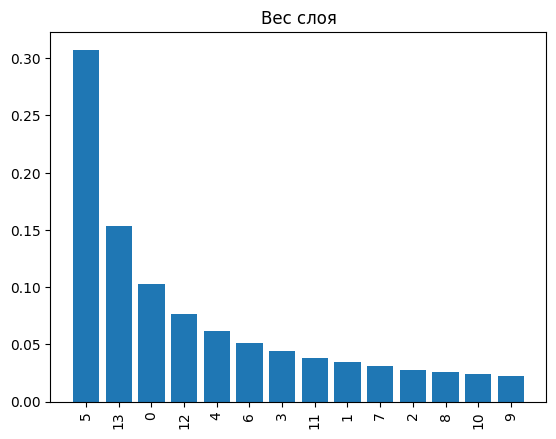

In [ ]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

## Общее сравнение

In [ ]:
dct_res = {}

with open(BASE_PATH+f"last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(BASE_PATH+f"best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(BASE_PATH+f"layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(BASE_PATH+f"concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_cluster'] = best

with open(BASE_PATH+f"concat_pca_qp_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_qp'] = best

with open(BASE_PATH+f"greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca_cluster,concat_pca_qp,greedy
0,0.758312,0.701656,0.763214,0.758864,0.76013,0.70724


# TweetSentimentExtractionClassification

In [31]:
task_names = ['TweetSentimentExtractionClassification']
sim_matr = load_res(BASE_PATH + 'CKA.pkl')

In [ ]:
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)

## Качество отдельных слоев на dev

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0.  Параметры
# ─────────────────────────────────────────────────────────────
PATH = BASE_PATH + f'layer_{task_names[0]}'

# ─────────────────────────────────────────────────────────────
# 1.  Загружаем датасет с вашими сплитами
# ─────────────────────────────────────────────────────────────

ds = load_dataset("mteb/tweet_sentiment_extraction")


# Разбиваем train → 80% train + 20% validation
train_val = ds["train"].train_test_split(test_size=0.2, seed=42)
ds_splits = DatasetDict({
    "train":      train_val["train"],
    "dev": train_val["test"],
    "test":       ds["test"]
})

# ─────────────────────────────────────────────────────────────
# 4.  Прогоняем по слоям 0–12
# ─────────────────────────────────────────────────────────────
all_results = {}
for layer in range(14):
    print(f"\n>>> Layer {layer}")
    res = evaluate_layer(layer, part_val = 'dev', max_iter = 1200)
    print(f"Accuracy: {res['accuracy']:.4f}")
    # print(res["report"])
    all_results[layer] = res
    save_res(all_results, PATH)

README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/195k [00:00<?, ?B/s]


>>> Layer 0
Accuracy: 0.6902

>>> Layer 1
Accuracy: 0.6958

>>> Layer 2
Accuracy: 0.6900

>>> Layer 3
Accuracy: 0.6922

>>> Layer 4
Accuracy: 0.6895

>>> Layer 5
Accuracy: 0.6937

>>> Layer 6
Accuracy: 0.6984

>>> Layer 7
Accuracy: 0.7120

>>> Layer 8
Accuracy: 0.7186

>>> Layer 9
Accuracy: 0.7191

>>> Layer 10
Accuracy: 0.7195

>>> Layer 11
Accuracy: 0.7180

>>> Layer 12
Accuracy: 0.7200

>>> Layer 13
Accuracy: 0.7188


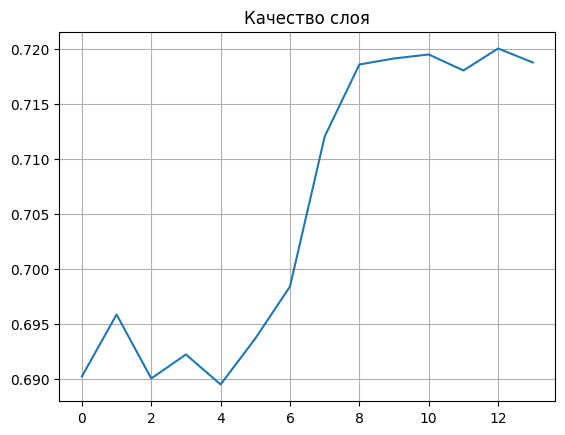

In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'

res = load_res(PATH)
res =np.array([i['accuracy'] for i in res.values()])
plt.plot(res)
plt.title('Качество слоя')
plt.grid()
plt.show()

In [ ]:
best_layer = np.argmax(res)

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

train.jsonl:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/465k [00:00<?, ?B/s]

main_score =  0.5973967176004528
CPU times: user 20.8 s, sys: 323 ms, total: 21.1 s
Wall time: 24.8 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.5823712507074137
CPU times: user 21.3 s, sys: 201 ms, total: 21.5 s
Wall time: 13.7 s


## Взвешанное среднее

In [32]:
layer_acc = load_res(BASE_PATH + f'layer_{task_names[0]}')
acc = np.array([i['accuracy'] for i in  layer_acc.values()])

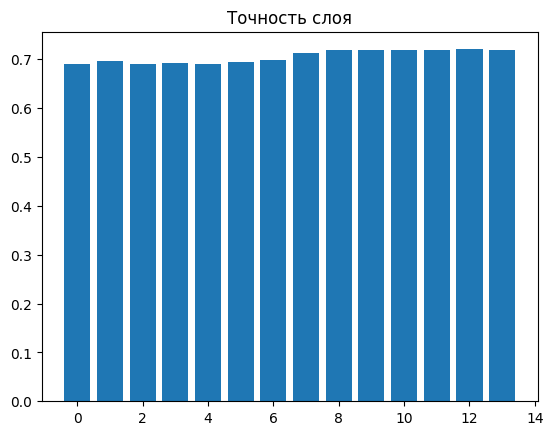

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
# plt.ylim(0.80, 0.91)
plt.show()

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.1)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

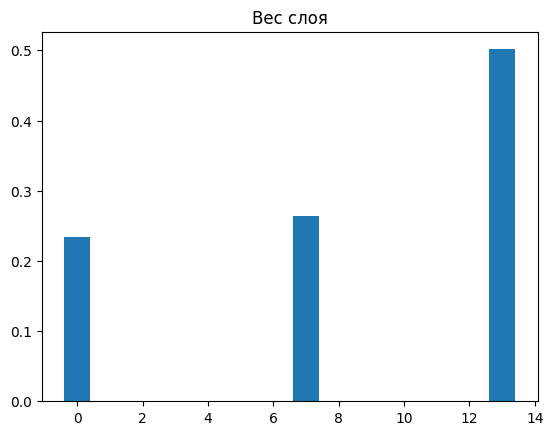

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.5972552348613469
CPU times: user 20.6 s, sys: 318 ms, total: 21 s
Wall time: 13.7 s


## QP nonsym

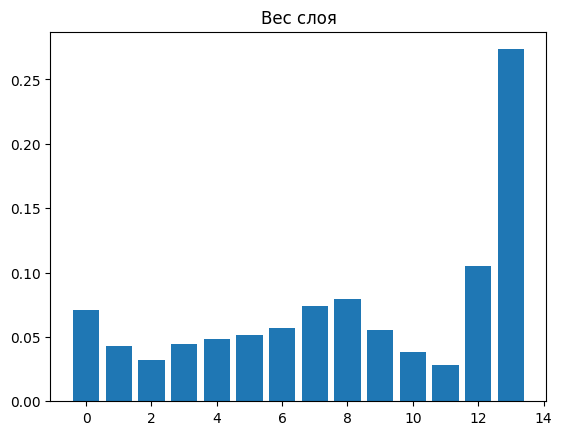

In [33]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [34]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

train.jsonl:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/465k [00:00<?, ?B/s]

main_score =  0.5837011884550085
CPU times: user 21 s, sys: 436 ms, total: 21.4 s
Wall time: 19.9 s


## PCA clusters

CLUSTERS:  [[0, 1, 2], [3, 4, 5, 6, 7, 8, 9, 10], [11, 12], [13]]


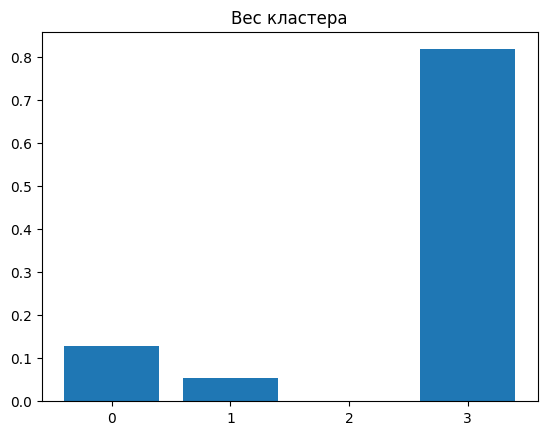

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
PATH = BASE_PATH + 'PCA/'
N_SENTENCES = 30_000
BATCH_GPU = 256

HIDDEN_SIZE = 768
CONCAT_DIM = HIDDEN_SIZE * len(CLUSTERS)
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)
POOLING = 'mean'


# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()
pooler_idx = mdl.config.num_hidden_layers + 1      # 13 для *-base

# ─────────────────────────────────────────────────────────────
# 3. Цикл по типам задач и их весам
# ─────────────────────────────────────────────────────────────

print(f"\n=== Обучение PCA для задачи: {task_names[0]} ===")

# Нормализация весов (на всякий случай)
weights = np.array(cluster_weights, dtype=np.float32)
weights = weights / weights.sum()
WEIGHTS = torch.tensor(weights)

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt",
                  padding=True, truncation=True, max_length=MAX_LEN
                 ).to(device)

        outs = mdl(**enc)                            # hidden + pooler
        h    = torch.stack(outs.hidden_states, 0)    # [L, B, T, H]

        vecs = []
        for idx_cl, cl in enumerate(CLUSTERS):
            per_layer_reprs = []

            for layer in cl:
                # ---- pooler_output как отдельный «слой» ----
                if layer == pooler_idx:
                    sent_repr = outs.pooler_output                # [B, H]
                else:                                             # обычный слой
                    h_l = h[layer]                                # [B, T, H]
                    if POOLING == "cls":
                        sent_repr = h_l[:, 0, :]                  # CLS
                    else:                                         # mean-pool
                        msk = enc.attention_mask.unsqueeze(-1).float()
                        sent_repr = (h_l * msk).sum(1) / msk.sum(1).clamp(min=1e-9)
                per_layer_reprs.append(sent_repr)

            # среднее по слоям внутри кластера (+ вес √w)
            cluster_vec = torch.stack(per_layer_reprs, 0).mean(0) * WEIGHTS[idx_cl].sqrt()
            vecs.append(cluster_vec)

        concat = torch.cat(vecs, -1).cpu().numpy()                # [B, concat_dim]

        buffer.append(concat)
        buf_len += concat.shape[0]
        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()


# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохраняем результат для задачи
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "clusters":   CLUSTERS,
    "weights":    WEIGHTS,
    "hidden_size": HIDDEN_SIZE,
    "pooling":    POOLING,            #  ←  сохраняем режим
}

out_path = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")


=== Обучение PCA для задачи: TweetSentimentExtractionClassification ===


  0%|          | 0/118 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/PCA/pca_divercity_TweetSentimentExtractionClassification.pt


In [ ]:
# CKPT_PATH  = f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_{task_names[0]}.pt"
# ckpt = torch.load(CKPT_PATH, map_location="cpu")

In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = ckpt['pooling'],
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

<ipython-input-9-6cedec8fb49f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights        = torch.tensor(weights, dtype=torch.float32)


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.6005942275042445


## PCA QP

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0. Параметры
# ─────────────────────────────────────────────────────────────
PATH = BASE_PATH + 'PCA/'
POOLING = 'mean'
N_SENTENCES = 30_000
BATCH_GPU = 256

HIDDEN_SIZE = 768
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# отобранные слои и их веса
selected_layers = weights_idx
final_acc = final_acc
final_acc /= final_acc.sum()  # нормализация
layer_weights = torch.tensor(final_acc, dtype=torch.float32)



# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()
pooler_idx = mdl.config.num_hidden_layers + 1      # 13 для *-base

# ─────────────────────────────────────────────────────────────
# 3. Обучение PCA на выбранных слоях
# ─────────────────────────────────────────────────────────────
print(f"\n=== Обучение PCA по отобранным слоям: {selected_layers.tolist()} ===")

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc   = tok(batch, return_tensors="pt",
                    padding=True, truncation=True, max_length=MAX_LEN
                   ).to(device)
        outs  = mdl(**enc)
        h     = torch.stack(outs.hidden_states, 0)   # [L, B, T, H]

        vecs = []
        for w_sqrt, layer_idx in zip(layer_weights.sqrt(), selected_layers):
            # ── pooler_output как отдельный «слой» ─────────────────
            if layer_idx == pooler_idx:
                sent = outs.pooler_output                     # [B, H]
            else:
                v = h[layer_idx]                              # [B, T, H]
                if POOLING == "cls":
                    sent = v[:, 0, :]                         # CLS
                else:                                         # mean-pool
                    m = enc.attention_mask.unsqueeze(-1).float()
                    sent = (v * m).sum(1) / m.sum(1).clamp(min=1e-9)
            # ────────────────────────────────────────────────────────
            vecs.append(sent * w_sqrt.to(sent.device))        # √w · vec

        concat = torch.cat(vecs, dim=-1).cpu().numpy()        # [B, len*H]
        buffer.append(concat);  buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat; gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохранение PCA
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "layers":     selected_layers.tolist(),
    "weights":    layer_weights,
    "hidden_size": HIDDEN_SIZE,
    "pooling": POOLING
}
out_path = os.path.join(PATH, f"pca_qadr_layers_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")


=== Обучение PCA по отобранным слоям: [0, 7, 13] ===


  0%|          | 0/118 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/PCA/pca_qadr_layers_TweetSentimentExtractionClassification.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = ckpt['pooling'],
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.602037351443124


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 14)

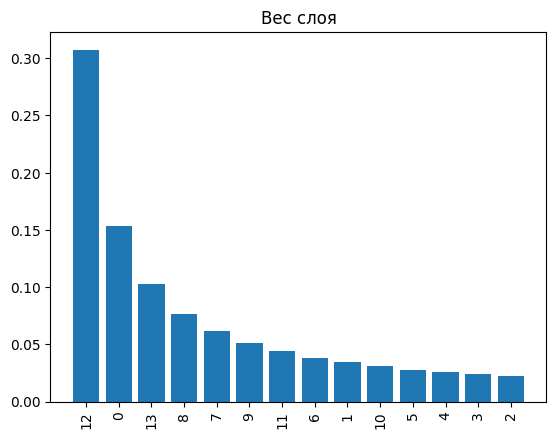

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.5923599320882852


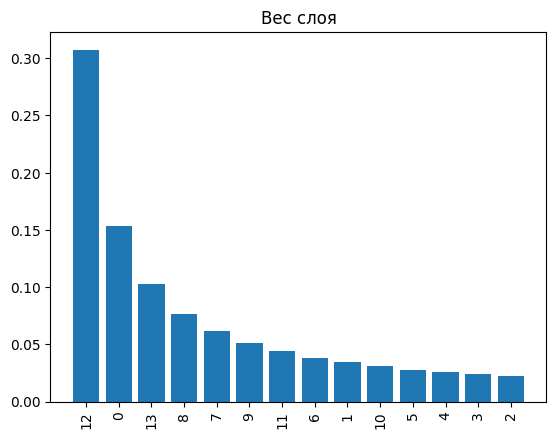

In [ ]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
# encoder = SelectedLayersEncoder(
#     selected_layers=selected,
#     layer_weights=weights,
#     pooling="mean",                # или "cls"
#     model_name=MODEL_NAME
# )

# tasks = mteb.get_tasks(
#     tasks=task_names,
#     languages=['eng'],            # только английский
# )
# evaluation = mteb.MTEB(tasks=tasks)
# results = evaluation.run(
#     encoder,
#     output_folder=BASE_PATH + f"greedy_v3_{task_names[0]}",
#     verbosity=1
# )

# print('main_score = ', results[0].scores['test'][0]['main_score'])

## Общее сравнение

In [ ]:
dct_res = {}

with open(BASE_PATH+f"last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(BASE_PATH+f"best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(BASE_PATH+f"layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(BASE_PATH+f"concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_cluster'] = best

with open(BASE_PATH+f"concat_pca_qp_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_qp'] = best

with open(BASE_PATH+f"greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca_cluster,concat_pca_qp,greedy
0,0.597397,0.62674,0.615393,0.638795,0.614827,0.63339


# NFCorpus

In [61]:
task_names = ['NFCorpus']
sim_matr = load_res(BASE_PATH + 'CKA.pkl')

## Качество отдельных слоев dev

In [ ]:
# a = mteb.get_tasks(tasks = task_names)
# a[0].metadata

In [ ]:
# Загружаем датасеты
ds = load_dataset("mteb/nfcorpus")
relevance_dev = ds["dev"]

queries = load_dataset("mteb/nfcorpus", name="queries", split="queries")
corpus  = load_dataset("mteb/nfcorpus", name="corpus",  split="corpus")

# Словари id → текст
qid2text = {q["_id"]: q["text"] for q in queries}
cid2text = {c["_id"]: c["text"] for c in corpus}

# Оставляем только id, участвующие в dev
query_ids_dev  = set([row["query-id"] for row in relevance_dev])
corpus_ids_dev = set([row["corpus-id"] for row in relevance_dev])

# Собираем тексты
queries_dev = [{"_id": qid, "text": qid2text[qid]} for qid in query_ids_dev if qid in qid2text]
corpus_dev  = [{"_id": cid, "text": cid2text[cid]} for cid in corpus_ids_dev if cid in cid2text]

README.md:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/7.26M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/748k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/810k [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/180k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/5.97M [00:00<?, ?B/s]

In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'


results = {}
for layer in range(14):
    print(f"→ Layer {layer}")
    encoder = SingleLayerEncoder(layer)
    metrics = evaluate_layer_nfcorpus(
        encoder = encoder,
        queries = queries_dev,
        corpus = corpus_dev,
        relevance = relevance_dev,
        top_k = 10
    )
    print(metrics)
    results[layer] = metrics
    save_res(results, PATH)

→ Layer 0
0.23148148148148148
→ Layer 1
0.2808641975308642
→ Layer 2
0.22530864197530864
→ Layer 3
0.1574074074074074
→ Layer 4
0.12654320987654322
→ Layer 5
0.11419753086419752
→ Layer 6
0.1111111111111111
→ Layer 7
0.12345679012345678
→ Layer 8
0.11728395061728394
→ Layer 9
0.12654320987654322
→ Layer 10
0.20987654320987653
→ Layer 11
0.3765432098765432
→ Layer 12
0.45987654320987653
→ Layer 13
0.4382716049382716


In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'
res = load_res(PATH)

In [ ]:
best_layer = np.argmax(list(res.values())).item()
best_layer

12

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.12997
CPU times: user 32.7 s, sys: 532 ms, total: 33.3 s
Wall time: 38 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH+f"best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.1439
CPU times: user 31.5 s, sys: 228 ms, total: 31.7 s
Wall time: 37.5 s


## Взвешанное среднее

In [62]:
layer_acc = load_res(BASE_PATH+f'layer_{task_names[0]}')
acc = np.array(list(layer_acc.values()))

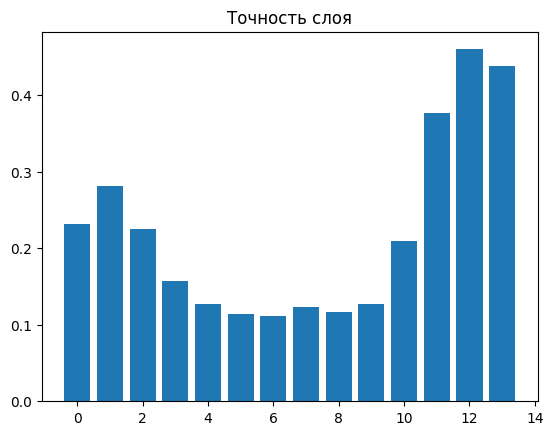

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
# plt.ylim(0.80, 0.91)
plt.show()

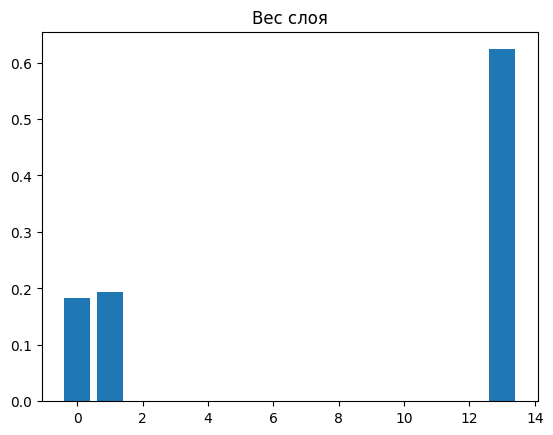

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
len(final_acc)

3

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.14417
CPU times: user 32.1 s, sys: 400 ms, total: 32.5 s
Wall time: 37.7 s


## QP nonsym

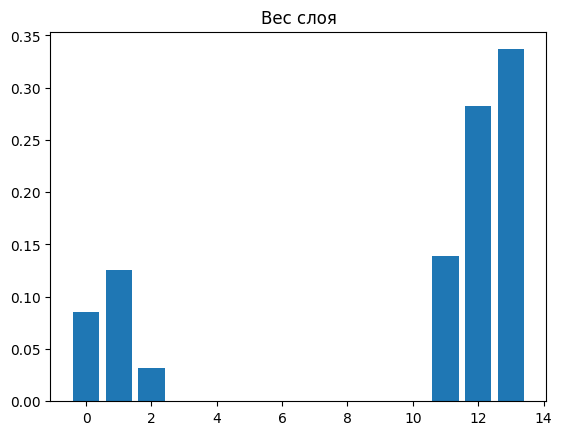

In [63]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [64]:
BASE_PATH

'/content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/'

In [65]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.13375
CPU times: user 708 ms, sys: 147 ms, total: 855 ms
Wall time: 1.57 s


## PCA cluster

CLUSTERS:  [[0, 1, 2], [3, 4, 5, 6, 7, 8, 9, 10], [11, 12], [13]]


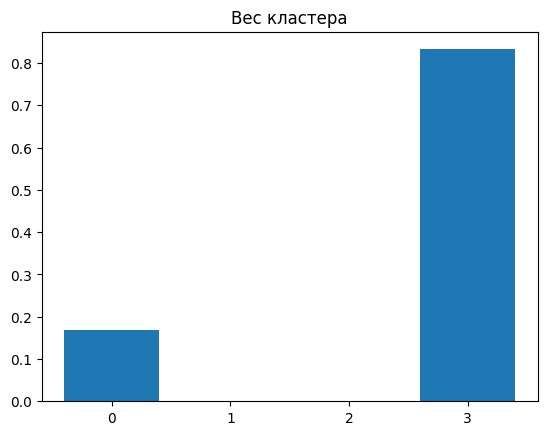

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
path, _ = train_pca_from_clusters(
    clusters        = CLUSTERS,
    cluster_weights = cluster_weights,
    task_name       = task_names[0],
)

PCA train batches:   0%|          | 0/469 [00:00<?, ?it/s]

✓ PCA saved → /content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/PCA/pca_clusters_NFCorpus.pt


In [ ]:
ckpt = torch.load(path, map_location="cpu")

In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = ckpt['pooling'],
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

<ipython-input-9-6cedec8fb49f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights        = torch.tensor(weights, dtype=torch.float32)


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.13633


## PCA QP

In [ ]:
path, ckpt = train_pca_from_selected_layers(
    selected_layers = weights_idx,      # например [0,4,8,13]
    layer_weights   = final_acc,        # массив тех же размеров
    task_name       = task_names[0],    # например 'Banking77'
    batch_gpu       = 256,
    pooling         = "mean",
    save_dir        = BASE_PATH + "PCA"
)

PCA batches:   0%|          | 0/118 [00:00<?, ?it/s]

✓ PCA saved → /content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/PCA/pca_selected_layers_NFCorpus.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = ckpt['pooling'],
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.1174


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 14)

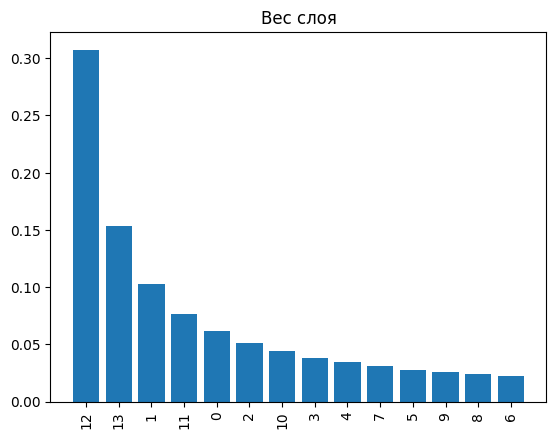

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling='mean',                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"/greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.09971


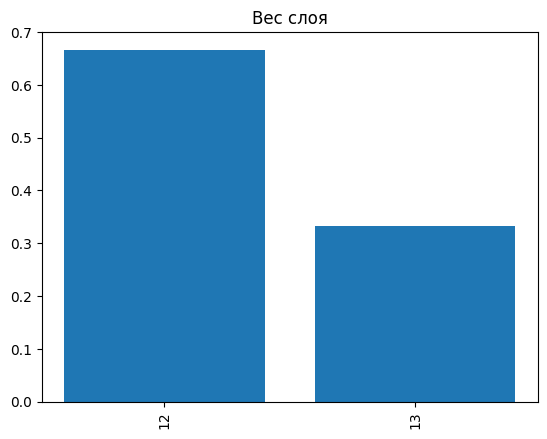

In [ ]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling='mean',                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"/greedy_v3_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

README.md:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/5.97M [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/180k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/7.26M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/748k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/810k [00:00<?, ?B/s]

main_score =  0.14545


## Общее сравнение

In [ ]:
dct_res = {}

with open(BASE_PATH+f"last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(BASE_PATH+f"best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(BASE_PATH+f"layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(BASE_PATH+f"concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_cluster'] = best

with open(BASE_PATH+f"concat_pca_qp_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_qp'] = best

with open(BASE_PATH+f"greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca_cluster,concat_pca_qp,greedy
0,0.12997,0.12988,0.10105,0.07056,0.12051,0.07221


# QuoraRetrieval

In [39]:
task_names = ['QuoraRetrieval']
sim_matr = load_res(BASE_PATH + 'CKA.pkl')

In [ ]:
# tasks = mteb.get_tasks(
#     tasks=task_names,
#     languages=['eng'],            # только английский
# )

## Качество отдельных слоев на dev

In [ ]:
# Загружаем датасеты
ds = load_dataset("mteb/quora")
relevance_dev = ds["dev"]

queries = load_dataset("mteb/quora", name="queries", split="queries")
corpus  = load_dataset("mteb/quora", name="corpus",  split="corpus")

# Словари id → текст
qid2text = {q["_id"]: q["text"] for q in queries}
cid2text = {c["_id"]: c["text"] for c in corpus}

# Оставляем только id, участвующие в dev
query_ids_dev  = set([row["query-id"] for row in relevance_dev])
corpus_ids_dev = set([row["corpus-id"] for row in relevance_dev])

# Собираем тексты
queries_dev = [{"_id": qid, "text": qid2text[qid]} for qid in query_ids_dev if qid in qid2text]
corpus_dev  = [{"_id": cid, "text": cid2text[cid]} for cid in corpus_ids_dev if cid in cid2text]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/453k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/930k [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/7626 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/15675 [00:00<?, ? examples/s]

queries.jsonl:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

Generating queries split:   0%|          | 0/15000 [00:00<?, ? examples/s]

corpus.jsonl:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/522931 [00:00<?, ? examples/s]

In [ ]:
PATH = BASE_PATH + f'/layer_{task_names[0]}'


results = {}
for layer in range(14):
    print(f"→ Layer {layer}")
    encoder = SingleLayerEncoder(layer)
    metrics = evaluate_layer_ndcg(
    encoder=encoder,
    queries=queries_dev,
    corpus=corpus_dev,
    relevance=relevance_dev,
    top_k=10
    )
    print(metrics)
    results[layer] = metrics
    save_res(results, PATH)

→ Layer 0


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

0.8845860580243953
→ Layer 1
0.9312682240763585
→ Layer 2
0.9349671964843966
→ Layer 3
0.9141574578787317
→ Layer 4
0.9048133298966518
→ Layer 5
0.8983986230288188
→ Layer 6
0.8884742591410213
→ Layer 7
0.8880706908072802
→ Layer 8
0.874336114958739
→ Layer 9
0.8507030660368702
→ Layer 10
0.9070658610969076
→ Layer 11
0.9476928365868754
→ Layer 12
0.9653467955271211
→ Layer 13
0.966986598415986


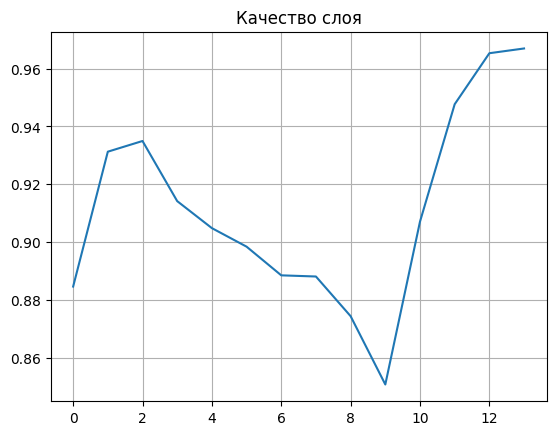

In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'

res = load_res(PATH)
res =np.array([i.item() for i in res.values()])
plt.plot(res)
plt.title('Качество слоя')
plt.grid()
plt.show()

In [ ]:
best_layer = np.argmax(res)

In [ ]:
BATCH_SIZE = 100

## среднее последнего слоя

In [40]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.79624
CPU times: user 732 ms, sys: 294 ms, total: 1.03 s
Wall time: 4.4 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.79624
CPU times: user 19min 31s, sys: 45.3 s, total: 20min 16s
Wall time: 17min 45s


## Взвешанное среднее

In [41]:
layer_acc = load_res(BASE_PATH + f'layer_{task_names[0]}')
acc = np.array([i.item() for i in  layer_acc.values()])

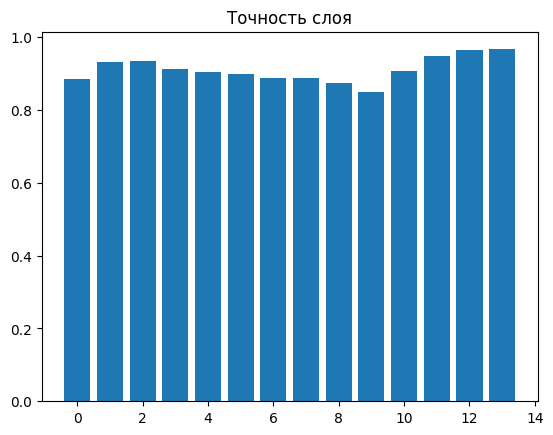

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
# plt.ylim(0.80, 0.94)
plt.show()

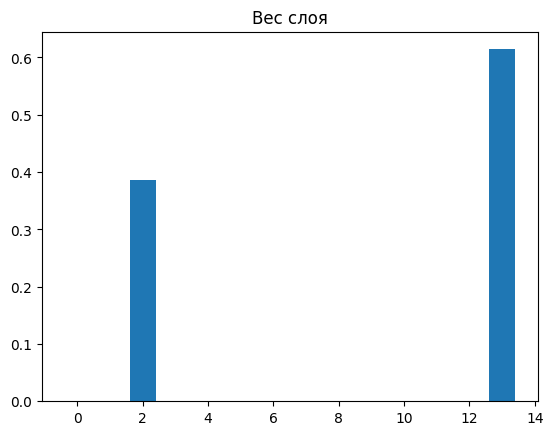

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.1)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

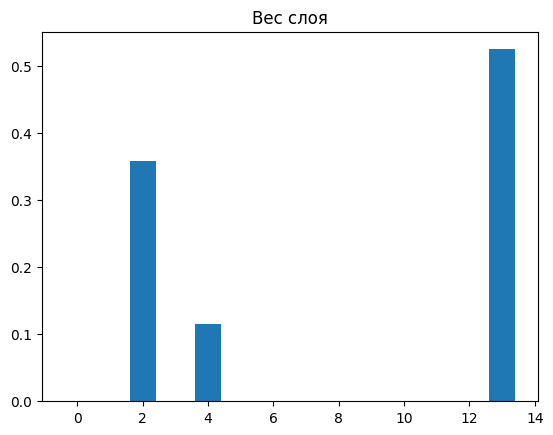

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.80641
CPU times: user 19min 34s, sys: 58.2 s, total: 20min 32s
Wall time: 18min 3s


## QP nonsym

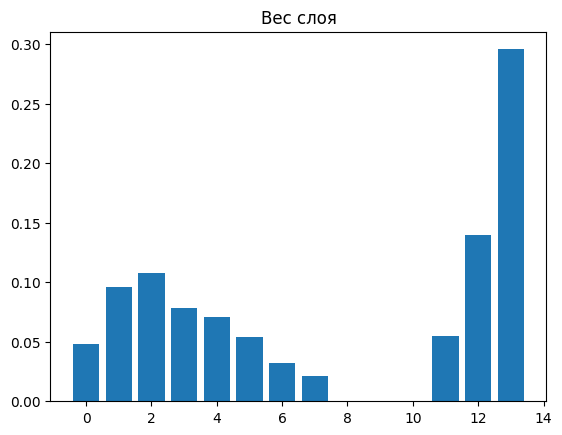

In [42]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [43]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

README.md:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/453k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/930k [00:00<?, ?B/s]

main_score =  0.78838
CPU times: user 20min 59s, sys: 56.2 s, total: 21min 56s
Wall time: 19min 30s


## PCA cluster

CLUSTERS:  [[0, 1, 2], [3, 4, 5, 6, 7, 8, 9, 10], [11, 12], [13]]


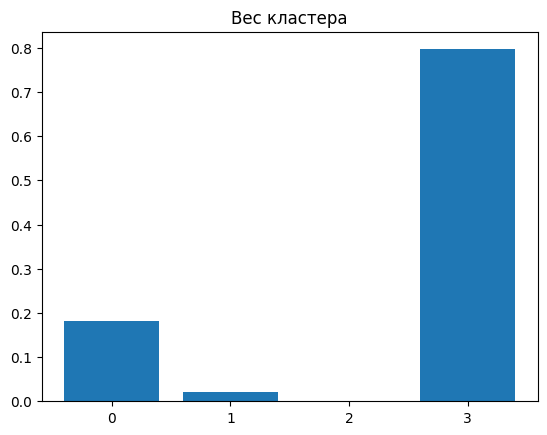

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
path, _ = train_pca_from_clusters(
    clusters        = CLUSTERS,
    cluster_weights = cluster_weights,
    task_name       = task_names[0],
)

ckpt = torch.load(path, map_location="cpu")

README.md:   0%|          | 0.00/41.1k [00:00<?, ?B/s]

PCA train batches:   0%|          | 0/469 [00:00<?, ?it/s]

✓ PCA saved → /content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/PCA/pca_clusters_QuoraRetrieval.pt


In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = ckpt['pooling'],
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

<ipython-input-11-6cedec8fb49f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights        = torch.tensor(weights, dtype=torch.float32)


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.79927


##PCA QP

In [ ]:
path, ckpt = train_pca_from_selected_layers(
    selected_layers = weights_idx,      # например [0,4,8,13]
    layer_weights   = final_acc,        # массив тех же размеров
    task_name       = task_names[0],    # например 'Banking77'
    batch_gpu       = 256,
    pooling         = "mean",
    save_dir        = BASE_PATH + "PCA"
)

PCA batches:   0%|          | 0/118 [00:00<?, ?it/s]

✓ PCA saved → /content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/PCA/pca_selected_layers_QuoraRetrieval.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = ckpt['pooling'],
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.80758


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 14)

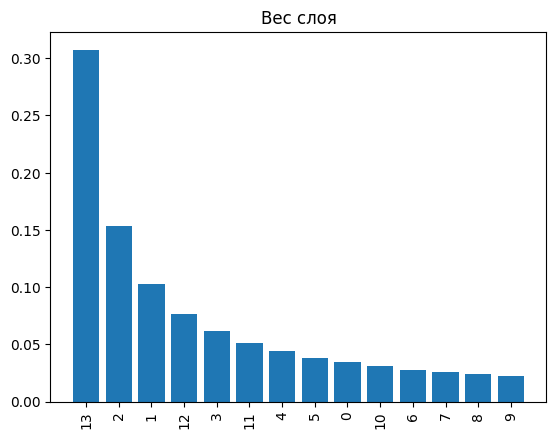

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.78128


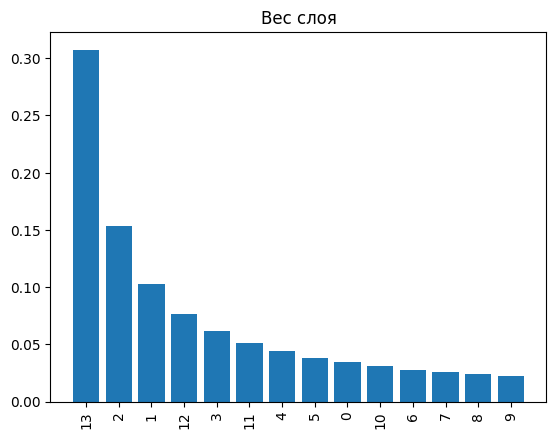

In [ ]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

то же самое, не пересчитываем

## Общее сравнение

In [ ]:
dct_res = {}

with open(BASE_PATH+f"last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(BASE_PATH+f"best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(BASE_PATH+f"layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(BASE_PATH+f"concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_cluster'] = best

with open(BASE_PATH+f"concat_pca_qp_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_qp'] = best

with open(BASE_PATH+f"greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

In [ ]:
from google.colab import runtime
runtime.unassign()

# STSBenchmark

In [45]:
task_names = ['STSBenchmark']
sim_matr = load_res(BASE_PATH + 'CKA.pkl')

## Качество отдельных слоев на dev

In [ ]:
ds = load_dataset("mteb/stsbenchmark-sts")
dev = ds["validation"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.67k [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/278k [00:00<?, ?B/s]

validation.jsonl.gz:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'

results = {}
for layer in range(14):
    print(f"\n>>> Layer {layer}")
    encoder = SingleLayerEncoder(layer)
    spearman = evaluate_layer_spearman(encoder, dev)
    print(f"Spearman = {spearman:.4f}")

    results[layer] = spearman
    save_res(results, PATH)


>>> Layer 0
Spearman = 0.6038

>>> Layer 1
Spearman = 0.6787

>>> Layer 2
Spearman = 0.6791

>>> Layer 3
Spearman = 0.6714

>>> Layer 4
Spearman = 0.6580

>>> Layer 5
Spearman = 0.6607

>>> Layer 6
Spearman = 0.6636

>>> Layer 7
Spearman = 0.6819

>>> Layer 8
Spearman = 0.6931

>>> Layer 9
Spearman = 0.7218

>>> Layer 10
Spearman = 0.7975

>>> Layer 11
Spearman = 0.8338

>>> Layer 12
Spearman = 0.8557

>>> Layer 13
Spearman = 0.8619


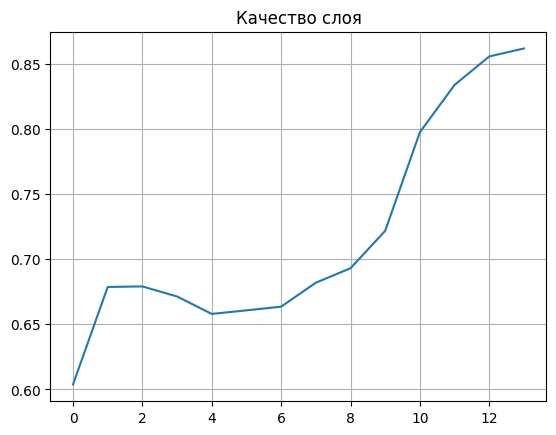

In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'

res = load_res(PATH)
res =np.array([i.item() for i in res.values()])
plt.plot(res)
plt.title('Качество слоя')
plt.grid()
plt.show()

In [ ]:
best_layer = np.argmax(res)

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH+f"/last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.84247
CPU times: user 663 ms, sys: 187 ms, total: 850 ms
Wall time: 1.55 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH+f"best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.826862
CPU times: user 660 ms, sys: 194 ms, total: 854 ms
Wall time: 1.55 s


## Взвешанное среднее

In [46]:
layer_acc = load_res(BASE_PATH+f'layer_{task_names[0]}')
acc = np.array([i.item() for i in  layer_acc.values()])

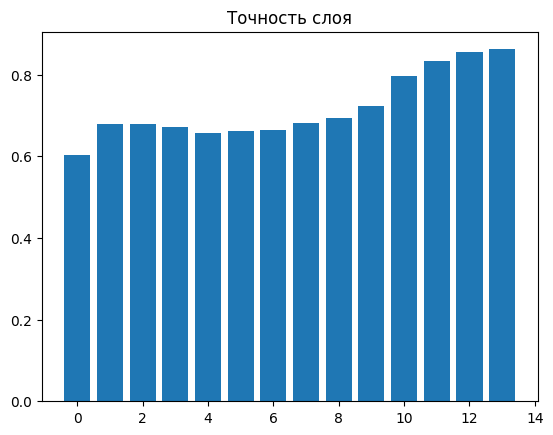

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
# plt.ylim(0.80, 0.94)
plt.show()

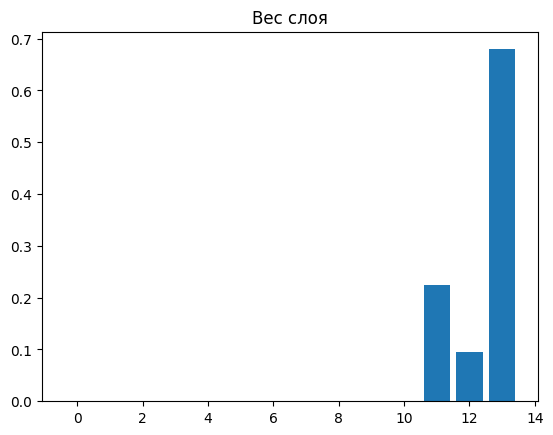

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.1)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

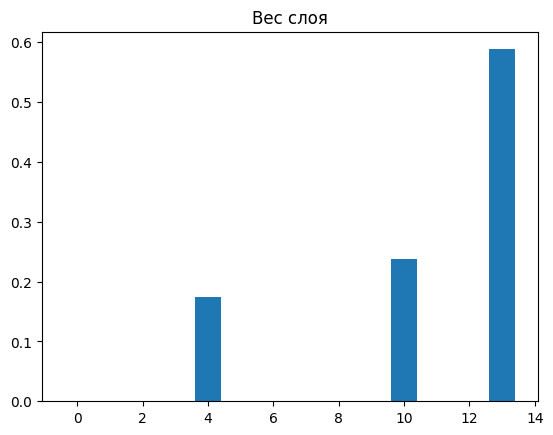

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH+f"layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.832657303341675
CPU times: user 3.38 s, sys: 266 ms, total: 3.65 s
Wall time: 6.55 s


## QP nonsym

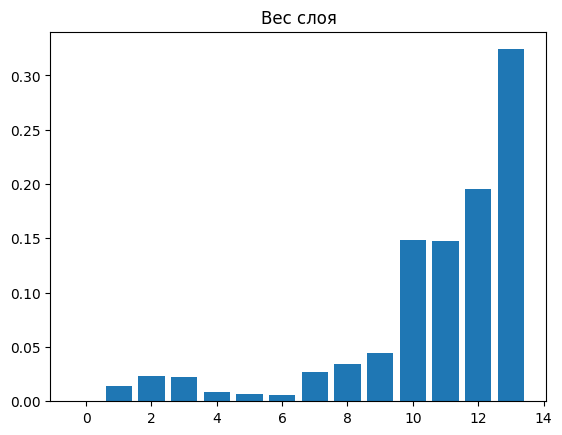

In [47]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [48]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

train.jsonl.gz:   0%|          | 0.00/278k [00:00<?, ?B/s]

validation.jsonl.gz:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

main_score =  0.8165930953414913
CPU times: user 3.87 s, sys: 234 ms, total: 4.1 s
Wall time: 13.2 s


## PCA cluster

CLUSTERS:  [[0, 1, 2], [3, 4, 5, 6, 7, 8, 9, 10], [11, 12], [13]]


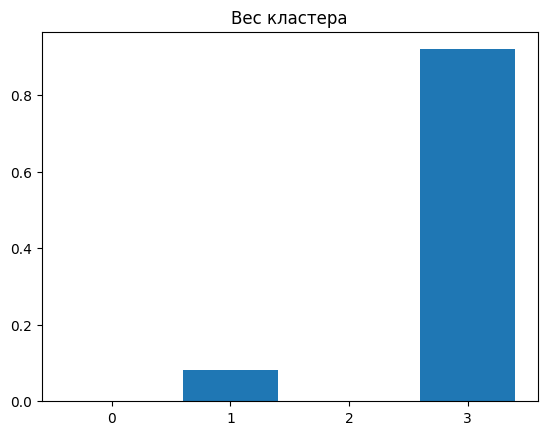

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
path, ckpt = train_pca_from_clusters(
    clusters        = CLUSTERS,
    cluster_weights = cluster_weights,
    task_name       = task_names[0],
)

README.md:   0%|          | 0.00/41.1k [00:00<?, ?B/s]

PCA train batches:   0%|          | 0/469 [00:00<?, ?it/s]

✓ PCA saved → /content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/PCA/pca_clusters_STSBenchmark.pt


In [ ]:
# CKPT_PATH  = f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_{task_names[0]}.pt"
# ckpt = torch.load(CKPT_PATH, map_location="cpu")

In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

<ipython-input-9-6cedec8fb49f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights        = torch.tensor(weights, dtype=torch.float32)


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.8422397463876449


## PCA qp

In [ ]:
path, ckpt = train_pca_from_selected_layers(
    selected_layers = weights_idx,      # например [0,4,8,13]
    layer_weights   = final_acc,        # массив тех же размеров
    task_name       = task_names[0],    # например 'Banking77'
    batch_gpu       = 256,
    pooling         = "mean",
    save_dir        = BASE_PATH + "PCA"
)

PCA batches:   0%|          | 0/118 [00:00<?, ?it/s]

✓ PCA saved → /content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/PCA/pca_selected_layers_STSBenchmark.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = ckpt['pooling'],
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.8309146782036495


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 14)

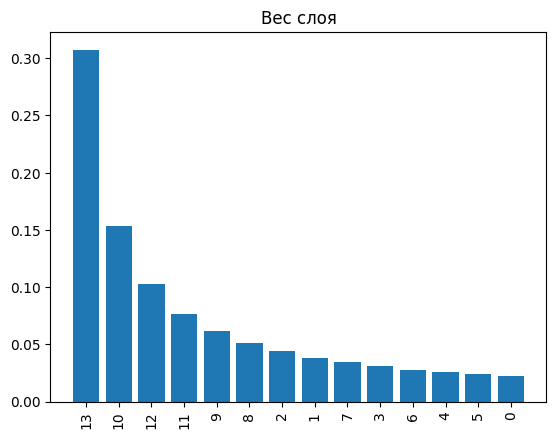

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.800810125351007


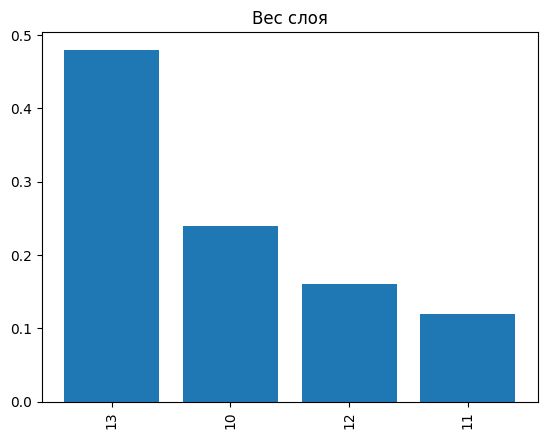

In [ ]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"greedy_v3_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

train.jsonl.gz:   0%|          | 0.00/278k [00:00<?, ?B/s]

validation.jsonl.gz:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

main_score =  0.8251980566821412


## Общее сравнение

In [ ]:
dct_res = {}

with open(BASE_PATH+f"last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(BASE_PATH+f"best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(BASE_PATH+f"layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(BASE_PATH+f"concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_cluster'] = best

with open(BASE_PATH+f"concat_pca_qp_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_qp'] = best

with open(BASE_PATH+f"greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

# SprintDuplicateQuestions

In [49]:
task_names = ['SprintDuplicateQuestions']
sim_matr = load_res(BASE_PATH + 'CKA.pkl')

## Качество отдельных слоев на dev

In [ ]:
# tasks = mteb.get_tasks(
#     tasks=task_names,
#     languages=['eng'],            # только английский
# )
# evaluation = mteb.MTEB(tasks=tasks)

In [ ]:
# tasks[0].load_data()

In [ ]:
# tasks[0].metadata

In [ ]:
dataset = load_dataset("mteb/sprintduplicatequestions-pairclassification", split="validation")

README.md:   0%|          | 0.00/7.69k [00:00<?, ?B/s]

validation.json.gz:   0%|          | 0.00/897k [00:00<?, ?B/s]

test.json.gz:   0%|          | 0.00/901k [00:00<?, ?B/s]

In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'


results = {}
# results = load_res(PATH)

for layer in range(14):
    print(f"\n>>> Layer {layer}")
    encoder = SingleLayerEncoder(layer)
    ap = evaluate_layer_ap(encoder, dataset)
    print(f"AP = {ap:.4f}")
    results[layer] = ap
    save_res(results, PATH)


>>> Layer 0
AP = 0.7063

>>> Layer 1
AP = 0.7667

>>> Layer 2
AP = 0.7502

>>> Layer 3
AP = 0.7152

>>> Layer 4
AP = 0.6321

>>> Layer 5
AP = 0.6341

>>> Layer 6
AP = 0.6252

>>> Layer 7
AP = 0.6360

>>> Layer 8
AP = 0.5605

>>> Layer 9
AP = 0.4353

>>> Layer 10
AP = 0.5474

>>> Layer 11
AP = 0.6855

>>> Layer 12
AP = 0.7545

>>> Layer 13
AP = 0.6033


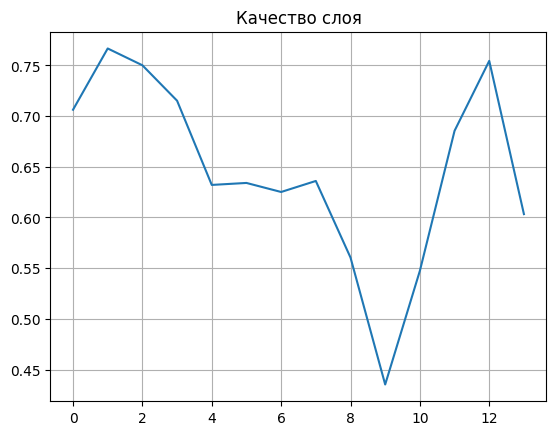

In [ ]:
PATH = BASE_PATH + f'layer_{task_names[0]}'

res = load_res(PATH)
res =np.array([i.item() for i in res.values()])
plt.plot(res)
plt.title('Качество слоя')
plt.grid()
plt.show()

In [ ]:
best_layer = np.argmax(res)

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.730439
CPU times: user 739 ms, sys: 194 ms, total: 933 ms
Wall time: 4.16 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.795813
CPU times: user 682 ms, sys: 197 ms, total: 879 ms
Wall time: 3.45 s


## Взвешанное среднее

In [50]:
layer_acc = load_res(BASE_PATH + f'layer_{task_names[0]}')
acc = np.array([i.item() for i in  layer_acc.values()])

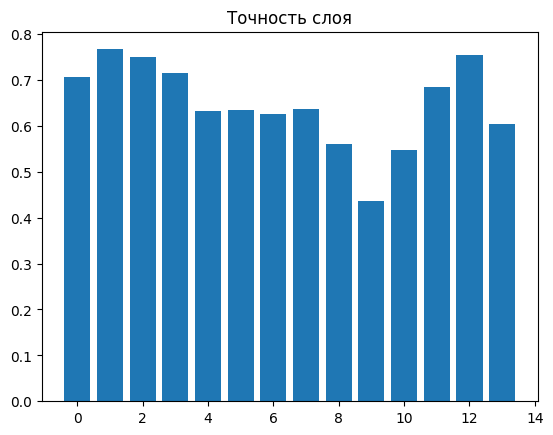

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
# plt.ylim(0.80, 0.94)
plt.show()

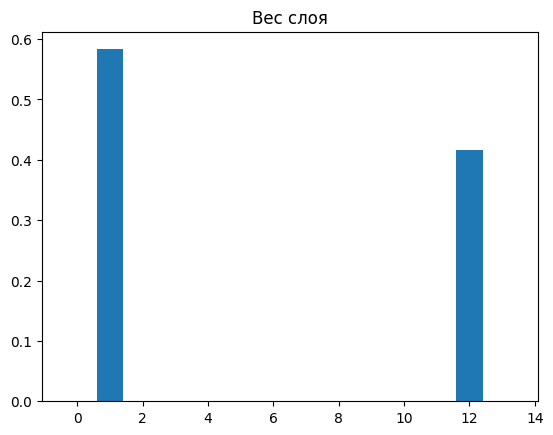

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.1)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

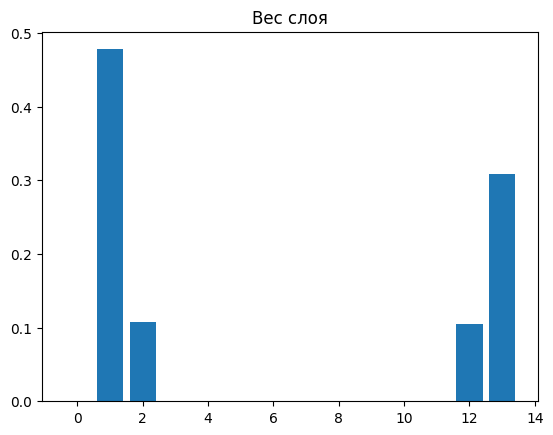

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"/layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.826183
CPU times: user 695 ms, sys: 204 ms, total: 899 ms
Wall time: 3.74 s


## QP nonsym

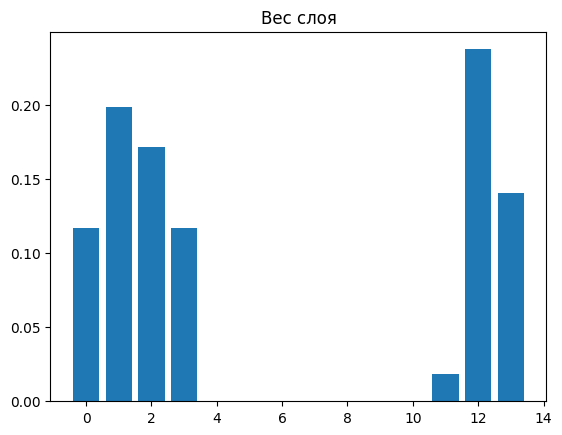

In [51]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [52]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

validation.json.gz:   0%|          | 0.00/897k [00:00<?, ?B/s]

test.json.gz:   0%|          | 0.00/901k [00:00<?, ?B/s]

main_score =  0.8326908093332666
CPU times: user 17.4 s, sys: 1.09 s, total: 18.5 s
Wall time: 26.4 s


## PCA cluster

CLUSTERS:  [[0, 1, 2], [3, 4, 5, 6, 7, 8, 9, 10], [11, 12], [13]]


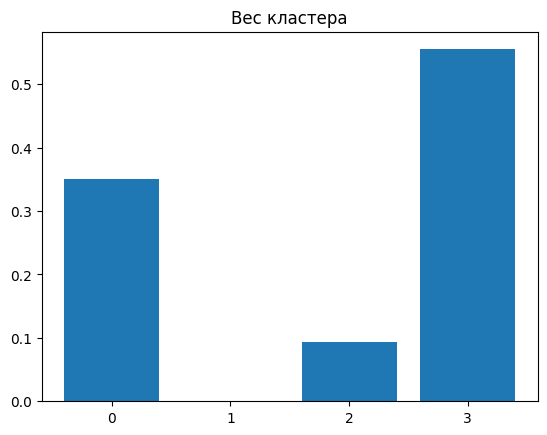

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
path, _ = train_pca_from_clusters(
    clusters        = CLUSTERS,
    cluster_weights = cluster_weights,
    task_name       = task_names[0],
)

ckpt = torch.load(path, map_location="cpu")

PCA train batches:   0%|          | 0/469 [00:00<?, ?it/s]

✓ PCA saved → /content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/PCA/pca_clusters_SprintDuplicateQuestions.pt


In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = ckpt['pooling'],
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

<ipython-input-9-6cedec8fb49f>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights        = torch.tensor(weights, dtype=torch.float32)


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

validation.json.gz:   0%|          | 0.00/897k [00:00<?, ?B/s]

test.json.gz:   0%|          | 0.00/901k [00:00<?, ?B/s]

main_score =  0.8143582178136793


## PCA qp

In [ ]:
path, ckpt = train_pca_from_selected_layers(
    selected_layers = weights_idx,      # например [0,4,8,13]
    layer_weights   = final_acc,        # массив тех же размеров
    task_name       = task_names[0],    # например 'Banking77'
    batch_gpu       = 256,
    pooling         = "mean",
    save_dir        = BASE_PATH + "PCA"
)

PCA batches:   0%|          | 0/118 [00:00<?, ?it/s]

✓ PCA saved → /content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/PCA/pca_selected_layers_SprintDuplicateQuestions.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = ckpt['pooling'],
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.83230419823895


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 14)

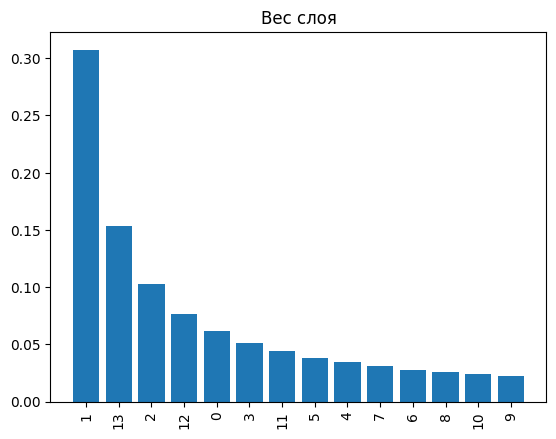

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.7962544674345045


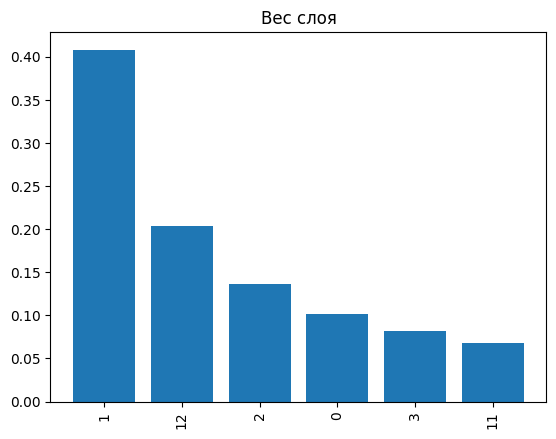

In [ ]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=BASE_PATH + f"greedy_v3_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

validation.json.gz:   0%|          | 0.00/897k [00:00<?, ?B/s]

test.json.gz:   0%|          | 0.00/901k [00:00<?, ?B/s]

main_score =  0.8272107043245318


## Общее сравнение

In [ ]:
f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json"

In [ ]:
dct_res = {}

with open(BASE_PATH+f"last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(BASE_PATH+f"best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(BASE_PATH+f"layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(BASE_PATH+f"concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_cluster'] = best

with open(BASE_PATH+f"concat_pca_qp_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_qp'] = best

with open(BASE_PATH+f"greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca_cluster,concat_pca_qp,greedy
0,0.494827,0.577143,0.577143,0.723224,0.723224,0.573745


In [ ]:
from google.colab import runtime
runtime.unassign()

# Результаты по всем задачам

In [11]:
import json
import pandas as pd
BASE_PATH = '/content/drive/MyDrive/PTLS/NLP/SIM-SCE_MEAN/'

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [12]:
def load_row(task_name):

  dct_res = {}

  with open(BASE_PATH + f"last_mean_mask_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['last_mean'] = best

  with open(BASE_PATH + f"best_dev_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['best_layer'] = best

  with open(BASE_PATH + f"layer_qp_mean_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['weighted_mean_qp'] = best

  with open(BASE_PATH + f"concat_pca_cluster_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['concat_pca_cluster'] = best

  with open(BASE_PATH + f"concat_pca_qp_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['concat_pca_qp'] = best

  with open(BASE_PATH + f"layer_qp_nonsym_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['qp_nonsym'] = best

  try:
    with open(BASE_PATH + f"greedy_v3_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
      best = json.load(f)['scores']['test'][0]['main_score']
      dct_res['greedy'] = best
  except:
    with open(BASE_PATH + f"greedy_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
      best = json.load(f)['scores']['test'][0]['main_score']
      dct_res['greedy'] = best


  return dct_res

In [13]:
task_names = ['Banking77Classification', 'TweetSentimentExtractionClassification', 'NFCorpus', 'QuoraRetrieval', 'STSBenchmark', 'SprintDuplicateQuestions']
# task_names = ['Banking77Classification', 'QuoraRetrieval', 'STSBenchmark', 'SprintDuplicateQuestions']

In [14]:
all_res = []
for task in task_names:
  all_res.append(load_row(task))

In [15]:
df = pd.DataFrame(all_res, index=task_names)

In [16]:
df

,last_mean,best_layer,weighted_mean_qp,concat_pca_cluster,concat_pca_qp,qp_nonsym,greedy
Banking77Classification,0.758312,0.701656,0.763214,0.758864,0.760130,0.759123,0.707240
TweetSentimentExtractionClassification,0.597397,0.582371,0.597255,0.600594,0.602037,0.583701,0.592360
NFCorpus,0.129970,0.143900,0.144170,0.136330,0.117400,0.133750,0.145450
QuoraRetrieval,0.796240,0.796240,0.806410,0.799270,0.807580,0.788380,0.781280
STSBenchmark,0.842470,0.826862,0.832657,0.842240,0.830915,0.816593,0.825198
SprintDuplicateQuestions,0.730439,0.795813,0.826183,0.814358,0.832304,0.832691,0.827211


In [17]:
df.to_csv(BASE_PATH +'SIMSCE_final_results_1.csv')